# Imports

In [2]:
!pip install pandas==2.2.1

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import RobustScaler
print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

C:\Users\TRETEC\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


pandas==2.2.1
numpy==1.26.4
seaborn==0.13.2


In [4]:
TRAIN_INPUT = "../data/x_train.csv"
TRAIN_OUTPUT = "../data/y_train.csv"
TEST_INPUT = "../data/x_test.csv"

In [5]:
x_train = pd.read_csv(TRAIN_INPUT, index_col= 'DELIVERY_START', parse_dates=True)
y_train = pd.read_csv(TRAIN_OUTPUT, index_col= 'DELIVERY_START', parse_dates=True)
x_test = pd.read_csv(TEST_INPUT, index_col= 'DELIVERY_START', parse_dates=True)

In [6]:
#datetime data
x_train.set_index(pd.to_datetime(x_train.index, utc=True), inplace=True)
y_train.set_index(pd.to_datetime(y_train.index, utc=True), inplace=True)
x_test.set_index(pd.to_datetime(x_test.index, utc=True), inplace=True)

# Summary
1. Samples are not all 1Hour-spaced
2. ~~Datetime column not in same timezone~~ --> Solved above using ``utc=True`` in the cell above
3. Data is balanced for classification 50% positive labels /50% negative labels
4. Missing values : most of values from column 'predicted_spot_price', and big chunk of data in 'load_forecast' missing during summer months of 2022
5. High correlations between : 
    * nuclear_power_available and coal_power_available
    * nuclear_power_available and load_forecast

# Detail

In [7]:
print(f"Training data : from {x_train.index.min()} to {x_train.index.max()}")
print(f"Test data : from {x_test.index.min()} to {x_test.index.max()}")

Training data : from 2022-01-01 01:00:00+00:00 to 2023-03-29 21:00:00+00:00
Test data : from 2023-04-01 22:00:00+00:00 to 2023-10-24 21:00:00+00:00


## 1. Sampling frequency : heterogeneous

In [8]:
x_train.index.diff().dropna().total_seconds().value_counts()

DELIVERY_START
3600.0      10595
90000.0         4
144000.0        1
43200.0         1
165600.0        1
262800.0        1
7200.0          1
Name: count, dtype: int64

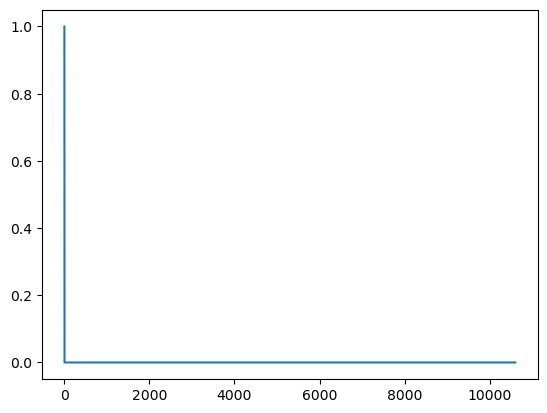

In [9]:
plt.plot(x_train.index.diff().isna().astype(int))

In [10]:
x_test.index.diff().dropna().total_seconds().value_counts()

DELIVERY_START
3600.0     4940
10800.0       1
Name: count, dtype: int64

In [11]:
differences = x_train.index.diff().total_seconds()/3600
indices = np.where(pd.Series(index=x_train.index,data=differences)>1.0)[0]
x_train.index[indices]
previous = list(map(lambda x:x-1, indices))
data = [(x_train.index[previous[i]],x_train.index[indices[i]],differences[indices[i]]) for i in range(len(indices))]
diff_spacings_train = pd.DataFrame(data, columns=['n-1','n','timedelta (hours)'])
diff_spacings_train

n-1                         n  timedelta (hours)
0 2022-02-12 22:00:00+00:00 2022-02-14 14:00:00+00:00               40.0
1 2022-03-29 21:00:00+00:00 2022-03-30 09:00:00+00:00               12.0
2 2022-03-30 09:00:00+00:00 2022-04-01 07:00:00+00:00               46.0
3 2022-05-28 21:00:00+00:00 2022-05-29 22:00:00+00:00               25.0
4 2022-06-10 21:00:00+00:00 2022-06-11 22:00:00+00:00               25.0
5 2022-06-15 21:00:00+00:00 2022-06-16 22:00:00+00:00               25.0
6 2022-09-13 21:00:00+00:00 2022-09-16 22:00:00+00:00               73.0
7 2022-10-30 00:00:00+00:00 2022-10-30 02:00:00+00:00                2.0
8 2023-02-23 22:00:00+00:00 2023-02-24 23:00:00+00:00               25.0

In [12]:
differences = x_test.index.diff().total_seconds()/3600
indices = np.where(pd.Series(index=x_test.index,data=differences)>1.0)[0]
x_test.index[indices]
previous = list(map(lambda x:x-1, indices))
data = [(x_test.index[previous[i]],x_test.index[indices[i]],differences[indices[i]]) for i in range(len(indices))]
diff_spacings_test = pd.DataFrame(data, columns=['n-1','n','timedelta (hours)'])
diff_spacings_test

n-1                         n  timedelta (hours)
0 2023-05-07 21:00:00+00:00 2023-05-08 00:00:00+00:00                3.0

In [13]:
x_train.index.inferred_freq

In [14]:
x_train['load_forecast']['2022-01'].index.inferred_freq

'h'

## 2. Is data balanced across classification labels

In [13]:
y_train_cls = (y_train>0).astype(int)
100*y_train_cls.value_counts()/y_train.shape[0]

spot_id_delta
1                50.165017
0                49.834983
Name: count, dtype: float64

## 3. Missing Values

In [15]:
x_train.isna().sum()

load_forecast                    1287
coal_power_available                1
gas_power_available                 1
nucelear_power_available            1
wind_power_forecasts_average       24
solar_power_forecasts_average      24
wind_power_forecasts_std           24
solar_power_forecasts_std          24
predicted_spot_price             8759
dtype: int64

<Axes: ylabel='DELIVERY_START'>

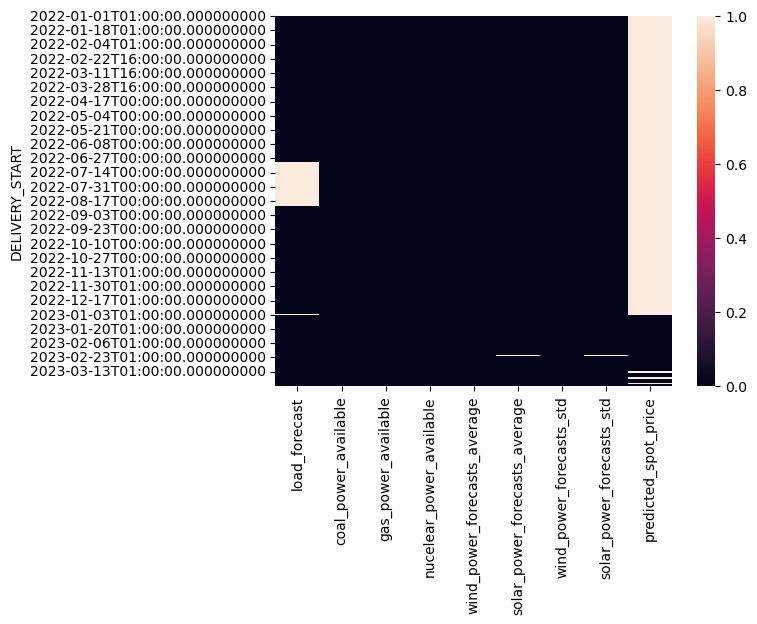

In [16]:
sns.heatmap(x_train.isna())

In [17]:
x_test.isna().sum()

load_forecast                       0
coal_power_available                0
gas_power_available                 0
nucelear_power_available            0
wind_power_forecasts_average        0
solar_power_forecasts_average      24
wind_power_forecasts_std            0
solar_power_forecasts_std          24
predicted_spot_price             1536
dtype: int64

<Axes: ylabel='DELIVERY_START'>

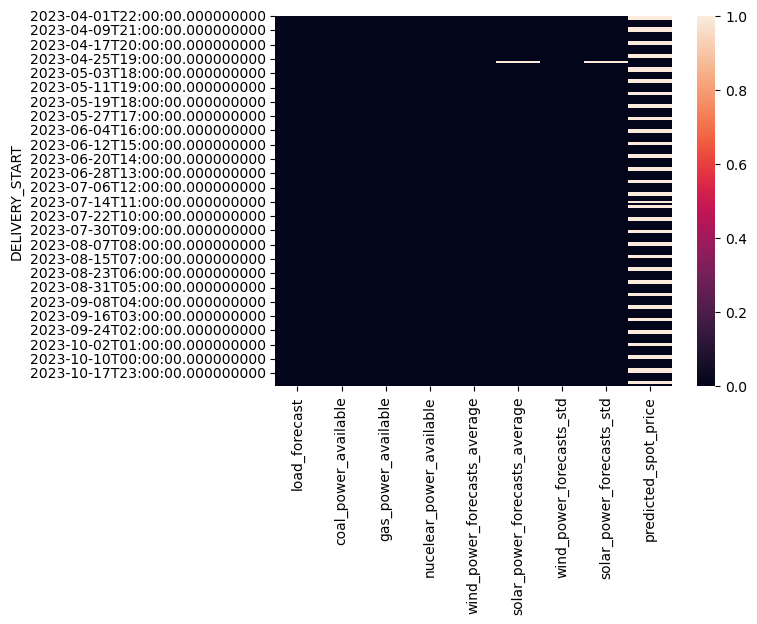

In [18]:
sns.heatmap(x_test.isna())

## 4. Feature distributions

<Axes: ylabel='Count'>

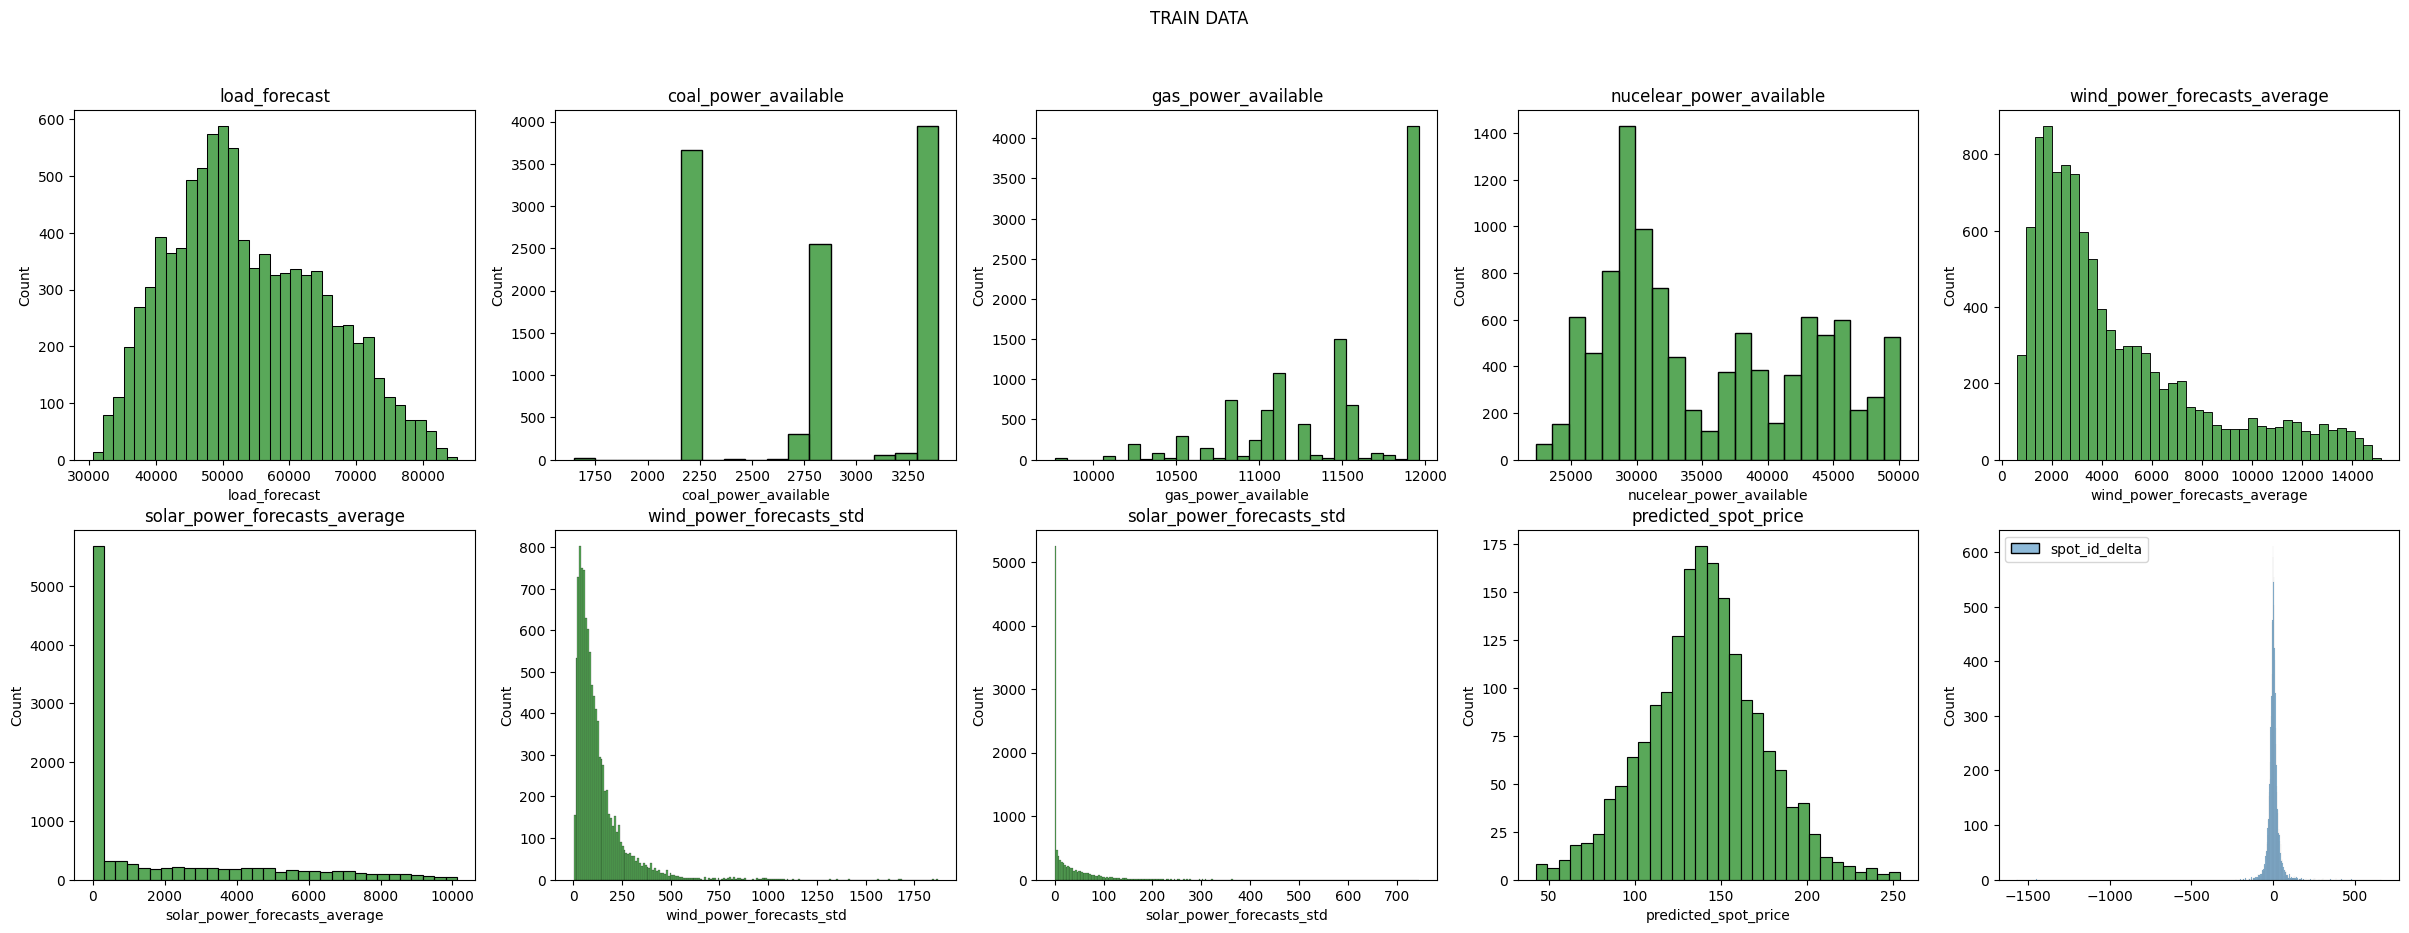

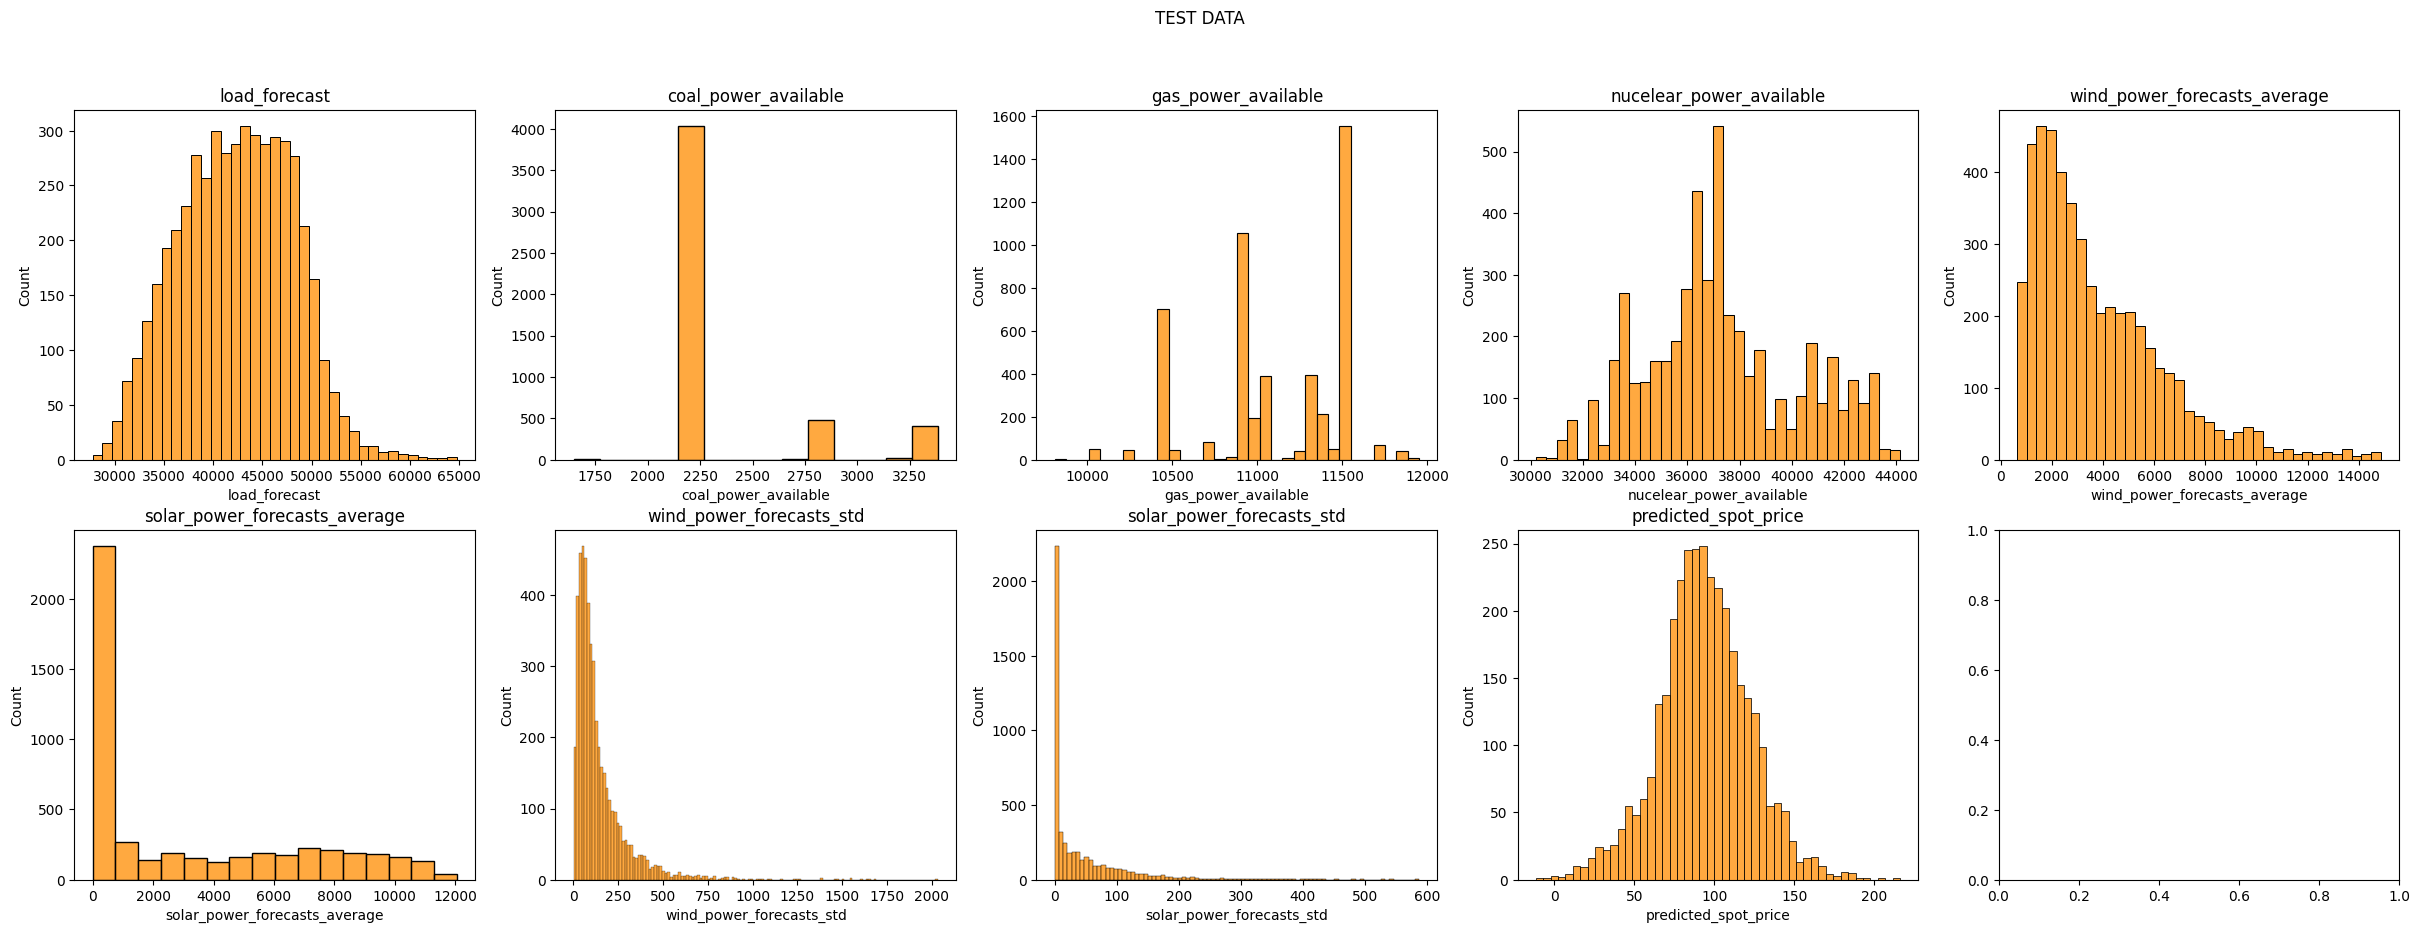

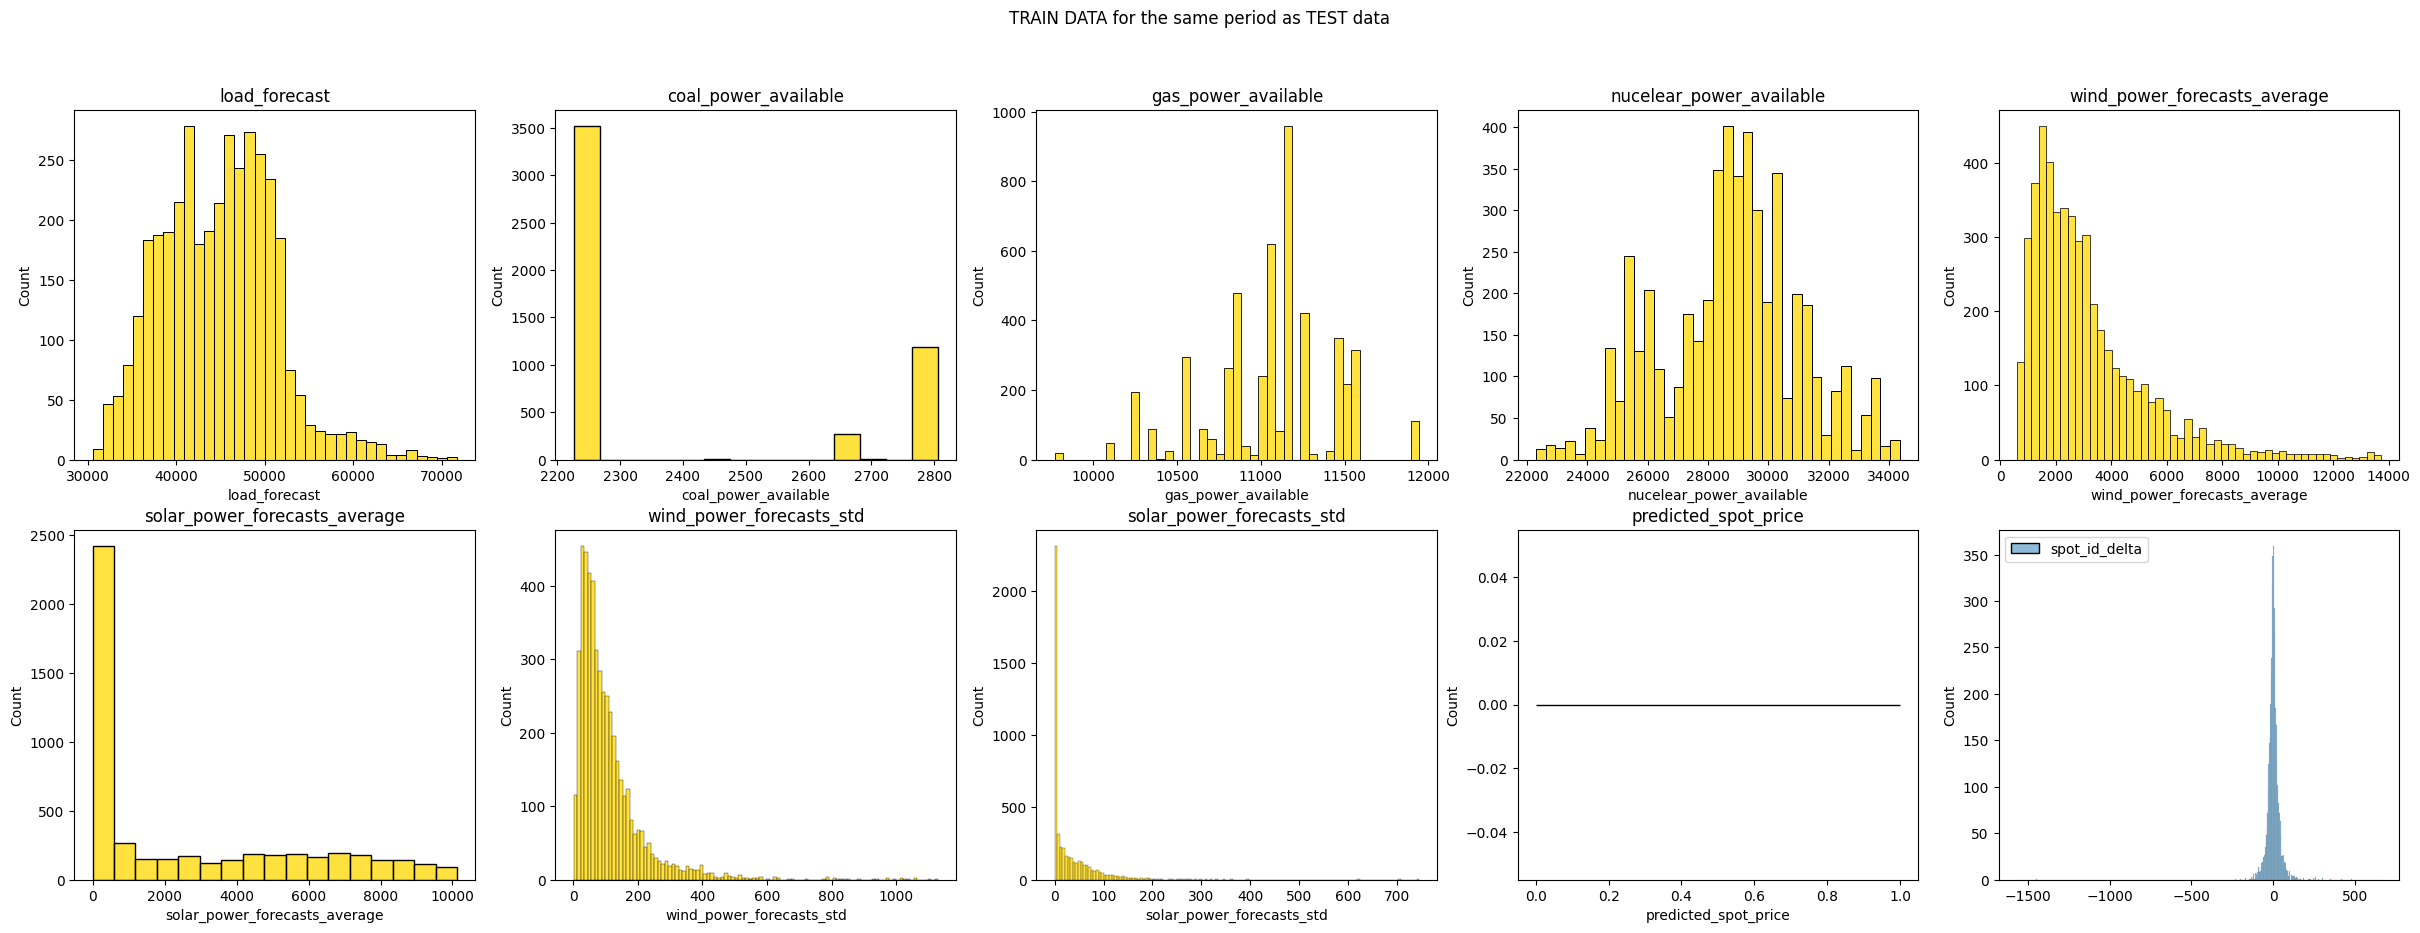

In [18]:
fig, axes = plt.subplots(nrows = 2, ncols = 5)    # axes is 2d array (3x3)
axes = axes.flatten()         # Convert axes to 1d array of length 9
fig.set_size_inches(30, 10)
fig.suptitle('TRAIN DATA')


for ax, col in zip(axes, x_train.columns):
  sns.histplot(x_train[col], ax = ax, color='forestgreen')
  ax.set_title(col)
sns.histplot(y_train, ax = axes[-1], color='forestgreen')

fig, axes = plt.subplots(nrows = 2, ncols = 5)    # axes is 2d array (3x3)
axes = axes.flatten()         # Convert axes to 1d array of length 9
fig.set_size_inches(30, 10)
fig.suptitle('TEST DATA')

for ax, col in zip(axes, x_test.columns):
  sns.histplot(x_test[col], ax = ax, color='darkorange')
  ax.set_title(col)

fig, axes = plt.subplots(nrows = 2, ncols = 5)    # axes is 2d array (3x3)
axes = axes.flatten()         # Convert axes to 1d array of length 9
fig.set_size_inches(30, 10)
fig.suptitle('TRAIN DATA for the same period as TEST data')

for ax, col in zip(axes, x_train.columns):
  sns.histplot(x_train['2022-04':'2022-10'][col], ax = ax, color='gold')
  ax.set_title(col)
sns.histplot(y_train['2022-04':'2022-10'], ax = axes[-1], color='gold')

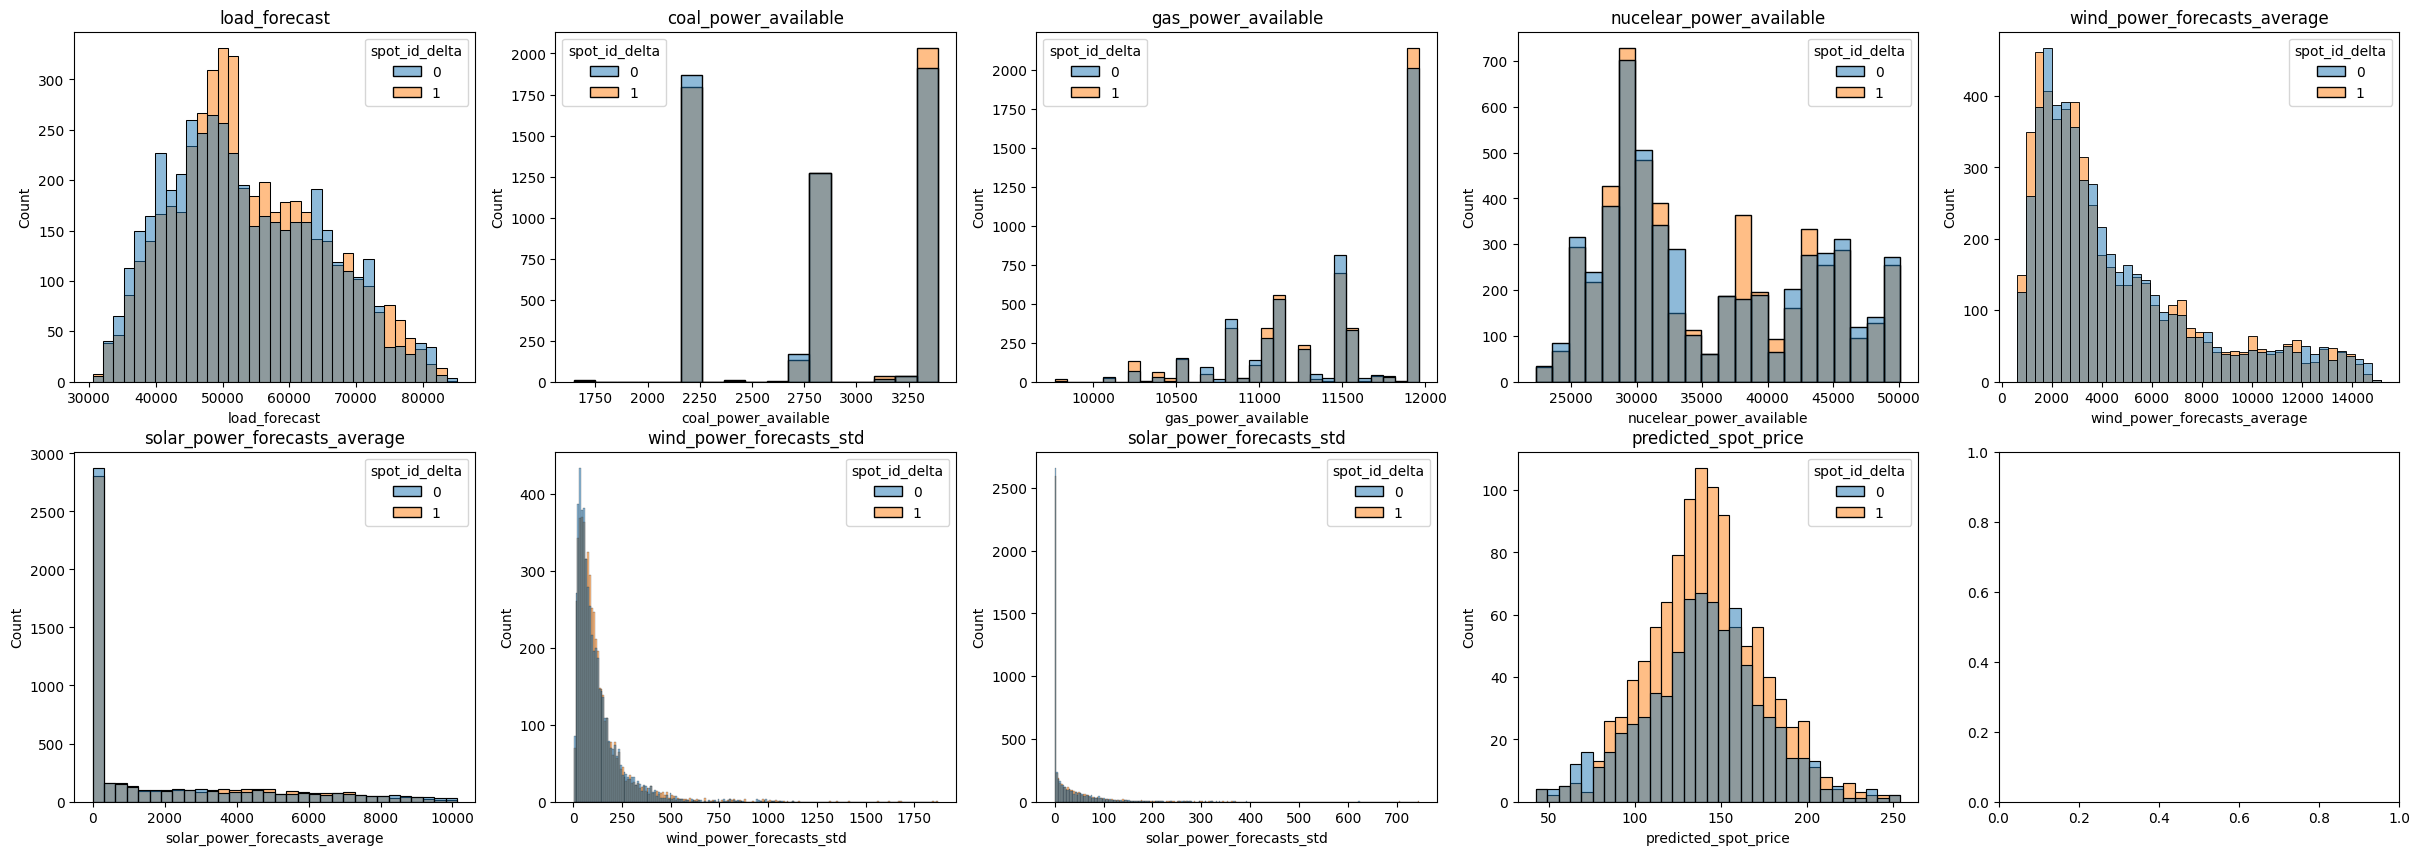

In [19]:
data = pd.concat([x_train,y_train_cls],axis=1)
fig, axes = plt.subplots(nrows = 2, ncols = 5)    # axes is 2d array (3x3)
axes = axes.flatten()         # Convert axes to 1d array of length 9
fig.set_size_inches(30, 10)

for ax, col in zip(axes, x_train.columns):
  sns.histplot(data=data, x=col, ax = ax, color='forestgreen', hue ='spot_id_delta')
  ax.set_title(col)


## 5. Feature time plots 

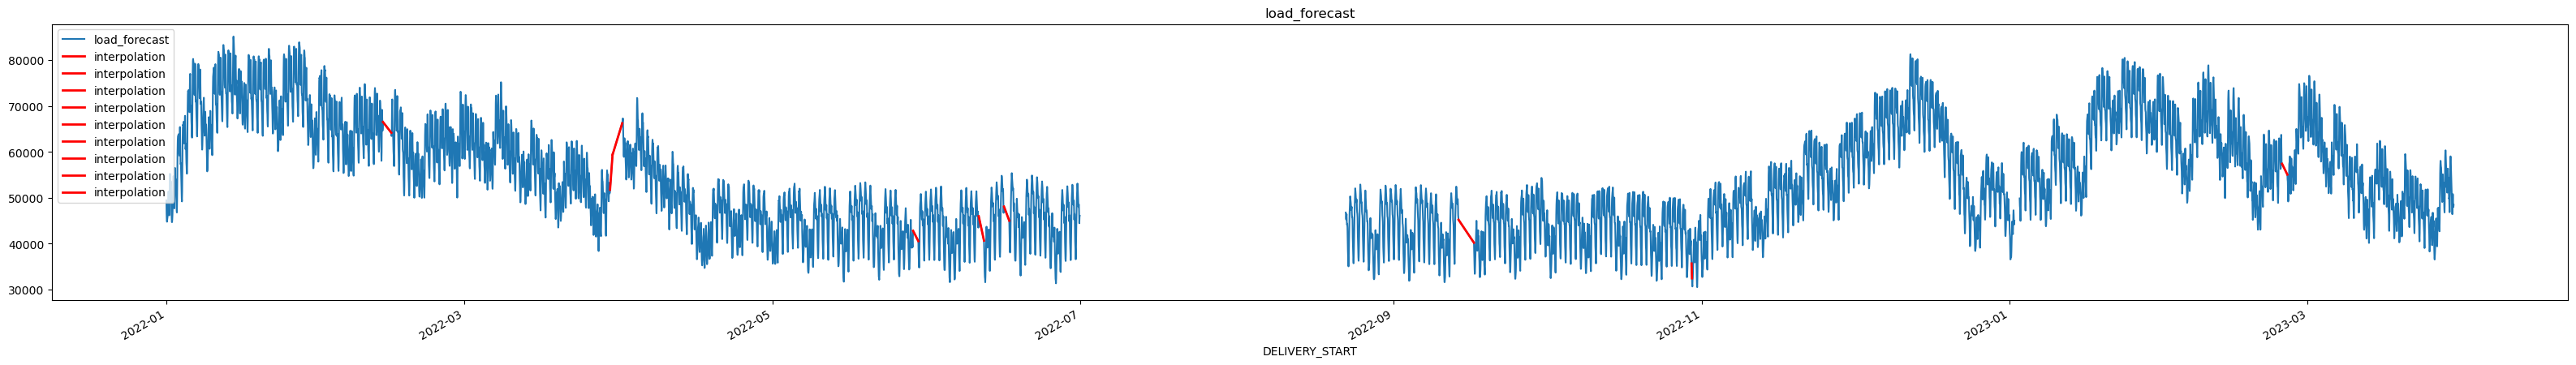

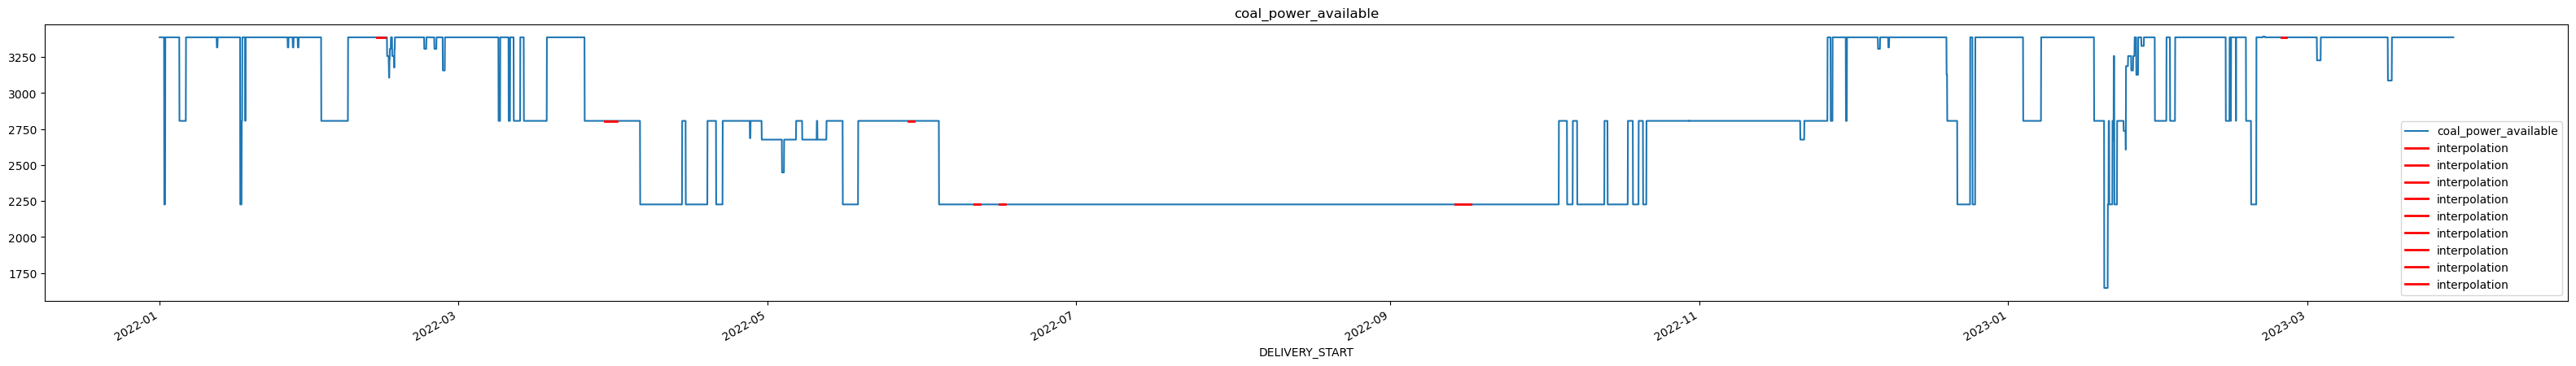

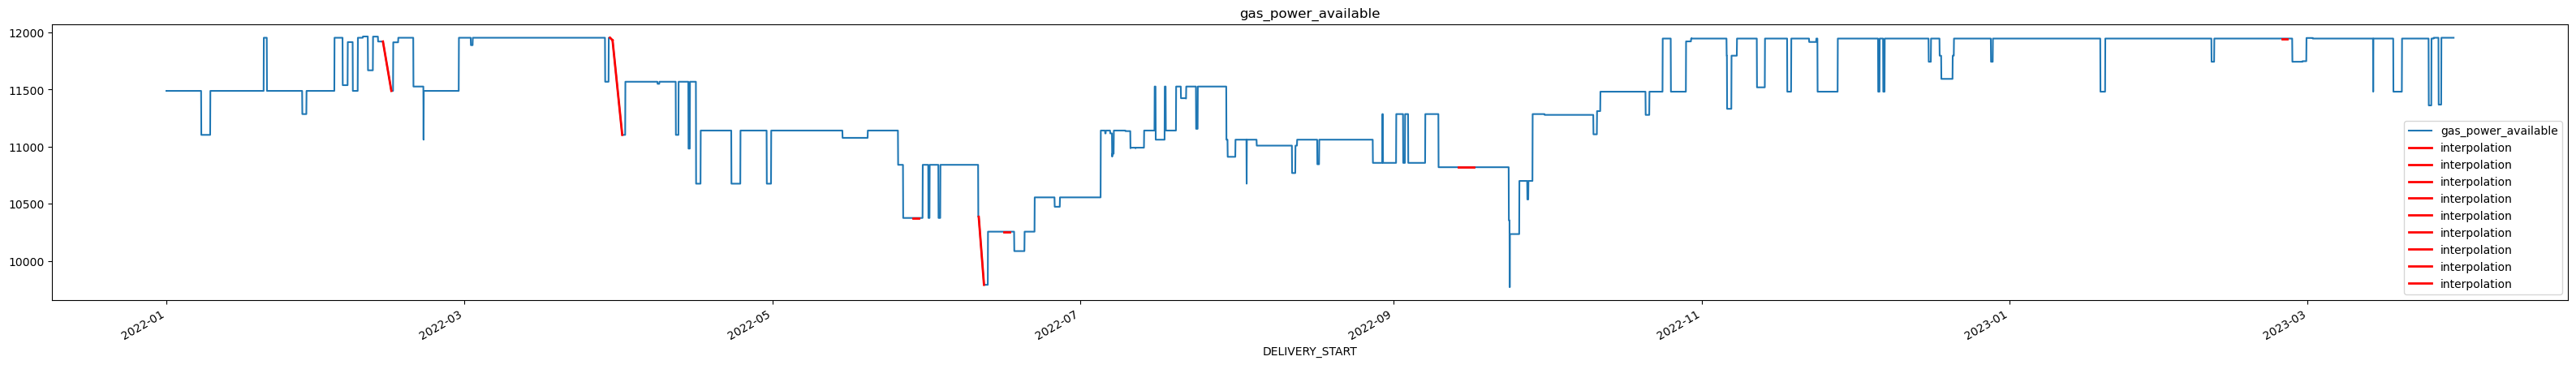

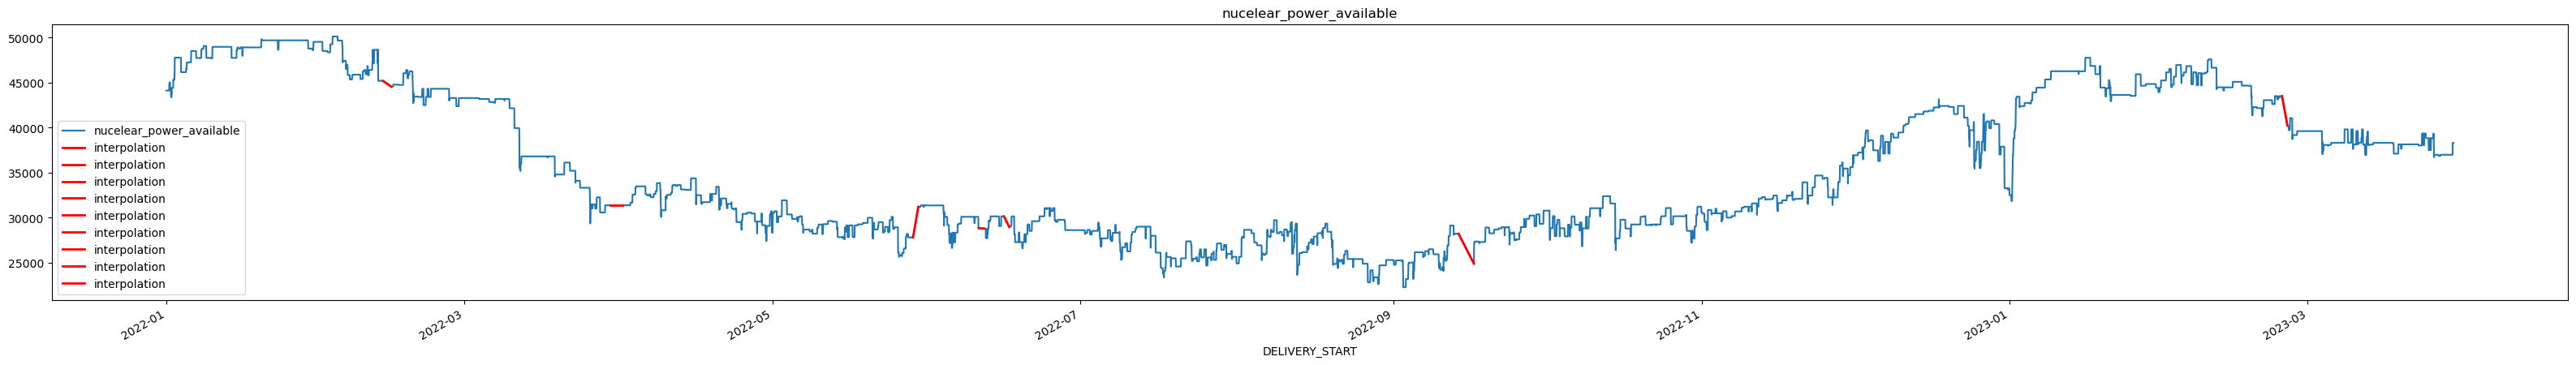

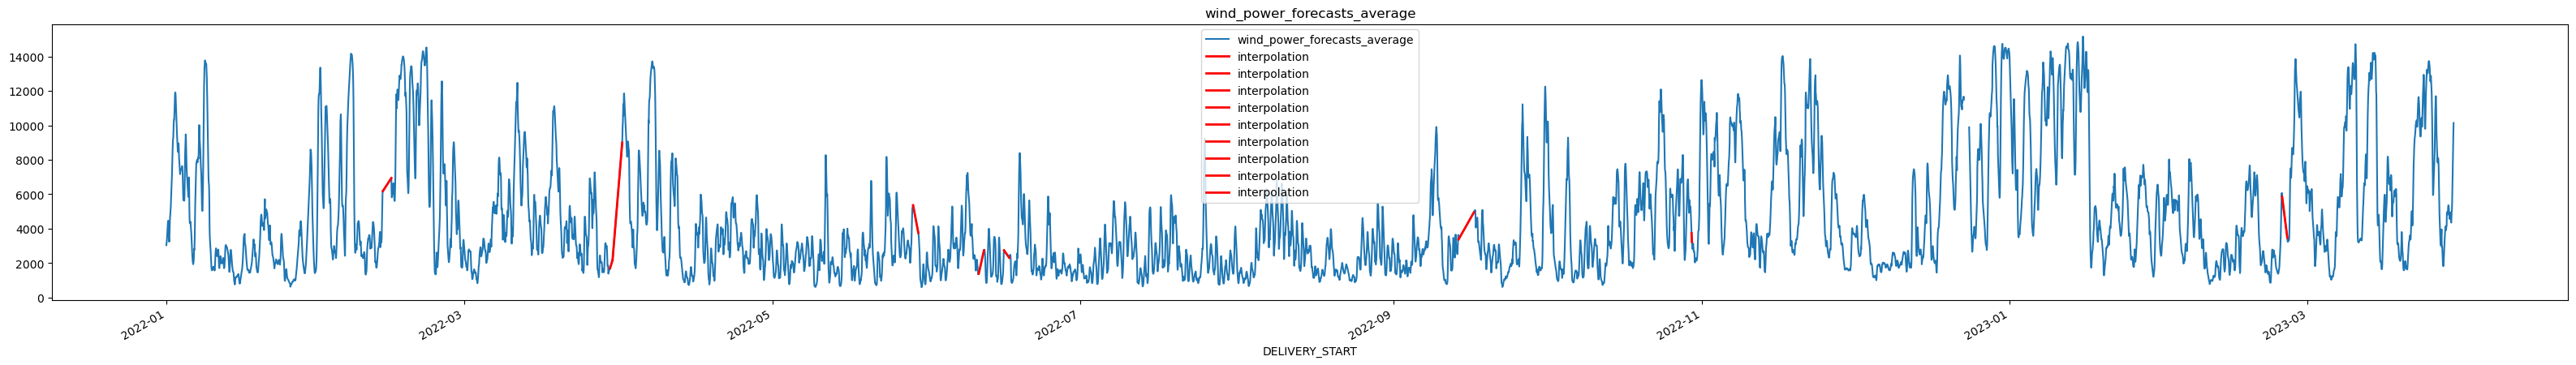

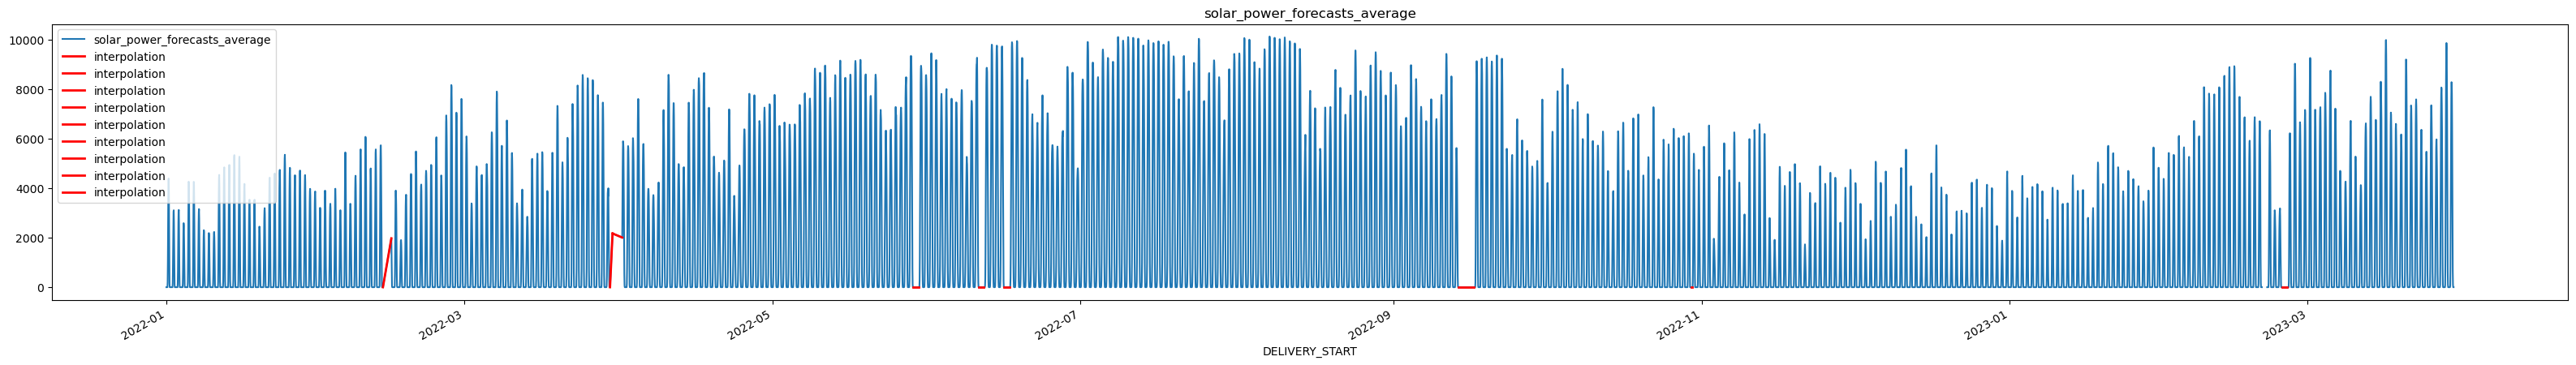

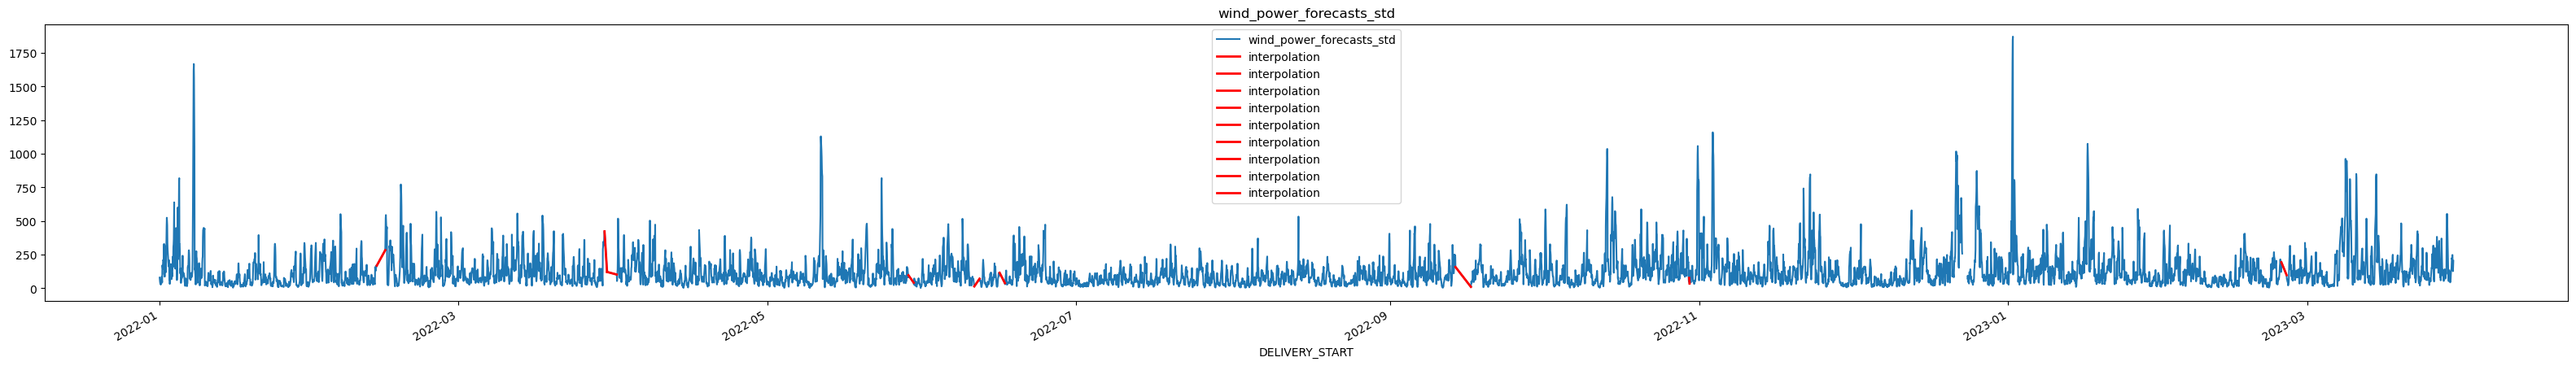

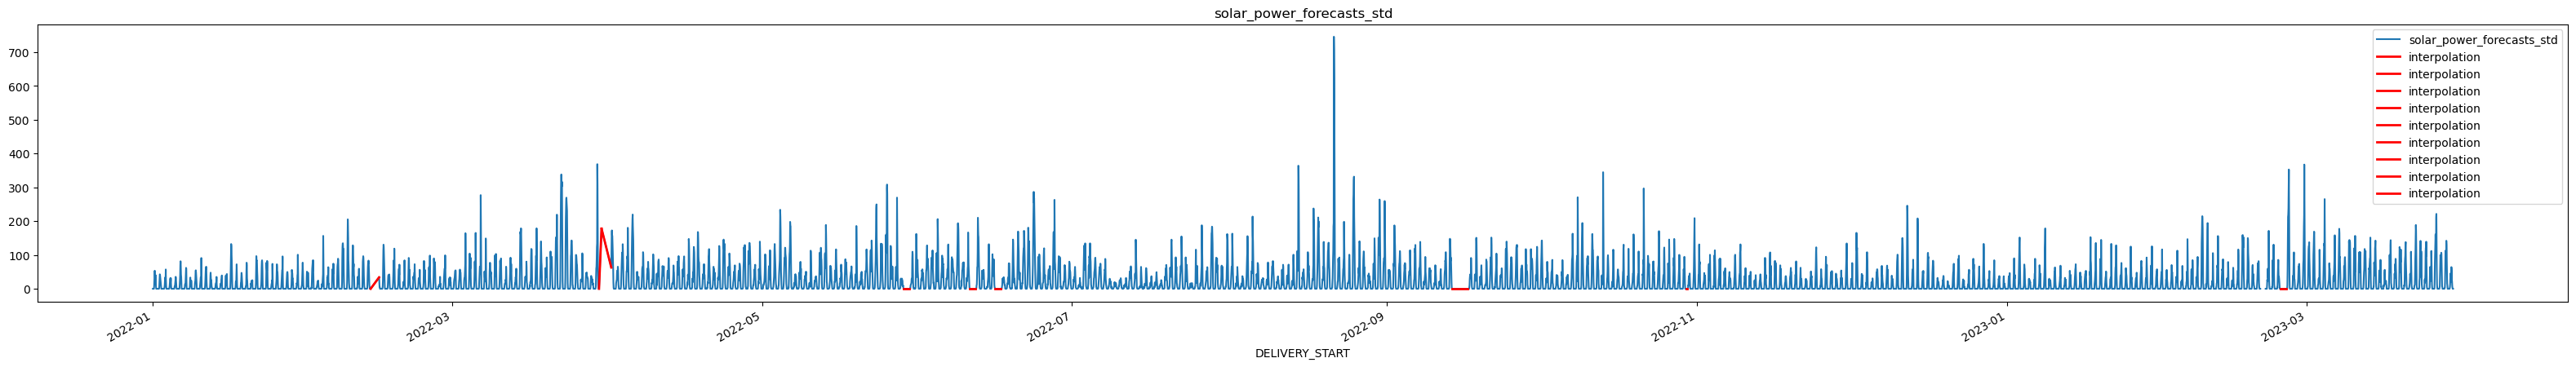

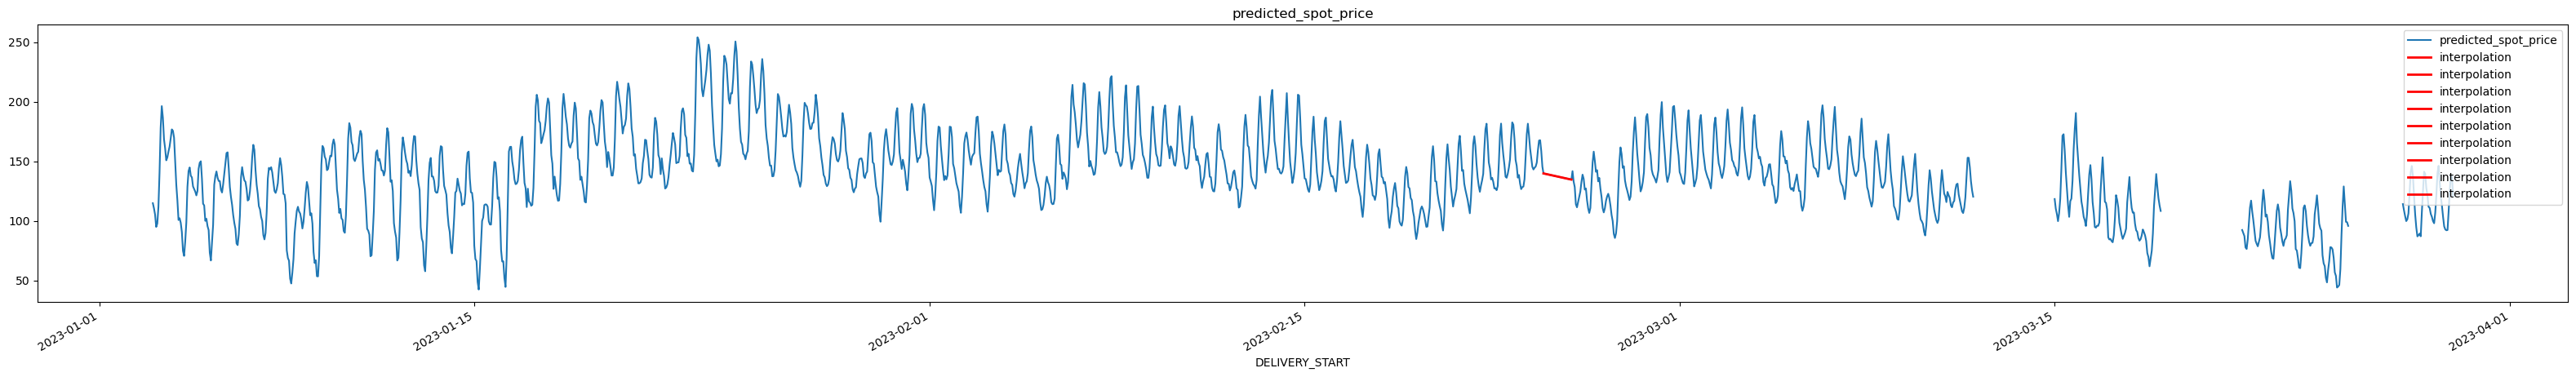

In [19]:
for col in x_train.columns:
    plt.figure(figsize=(40,5))
    x_train[col].plot()
    for _,line in diff_spacings_train.iterrows():
        x_train[col][line['n-1']:line['n']].plot(color='red',linewidth='2', label = 'interpolation')
    plt.legend()
    plt.title(col)
    plt.show()

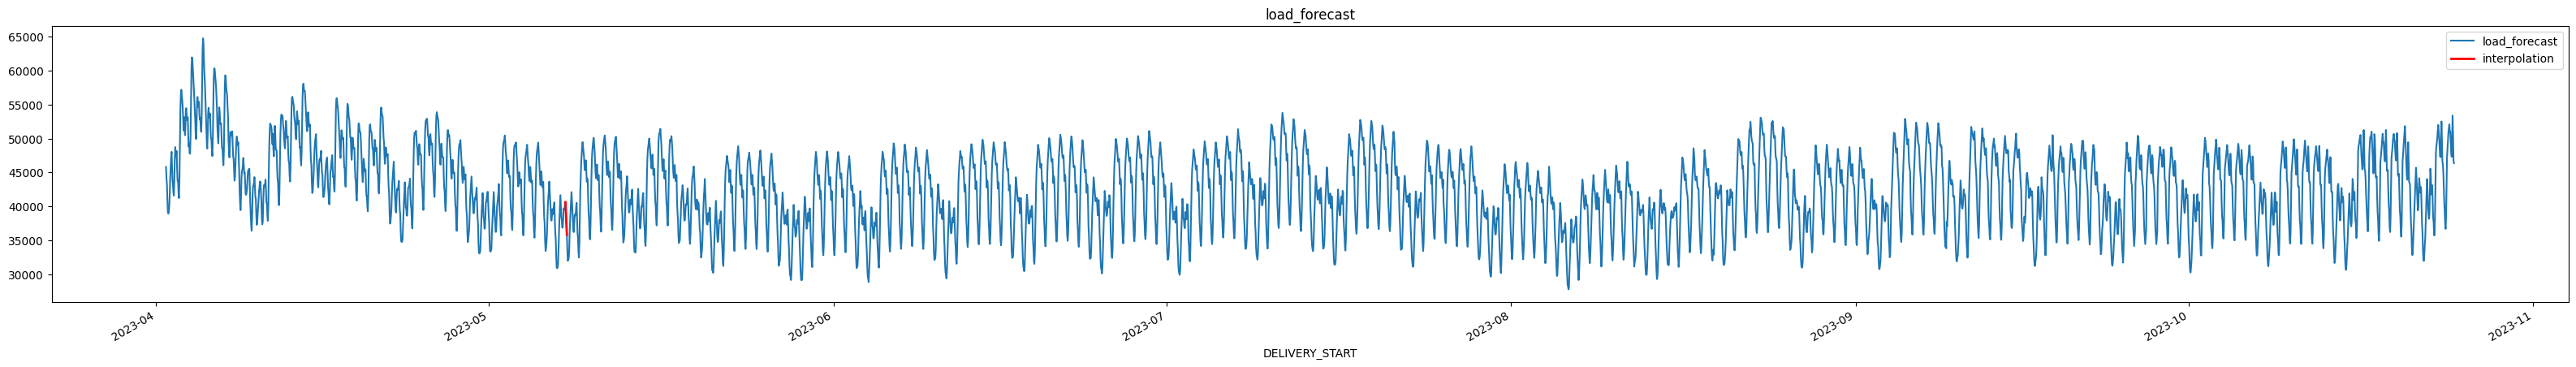

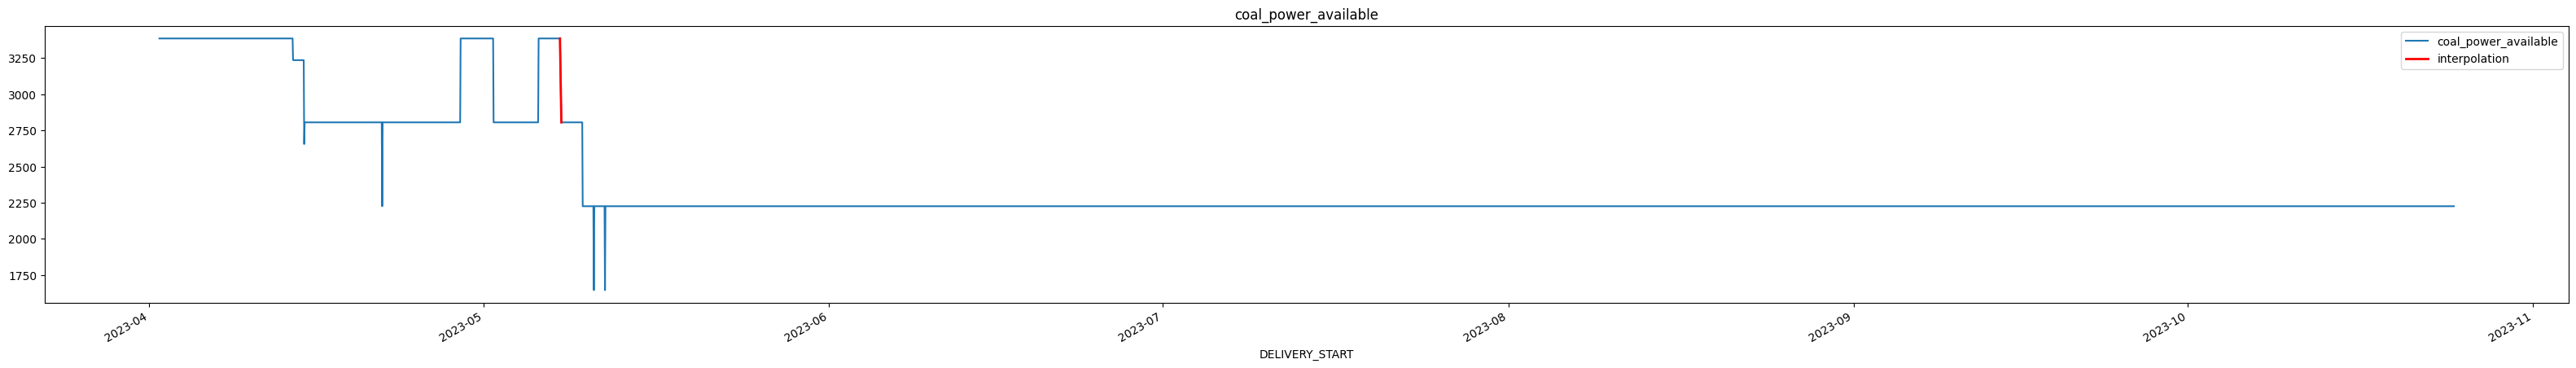

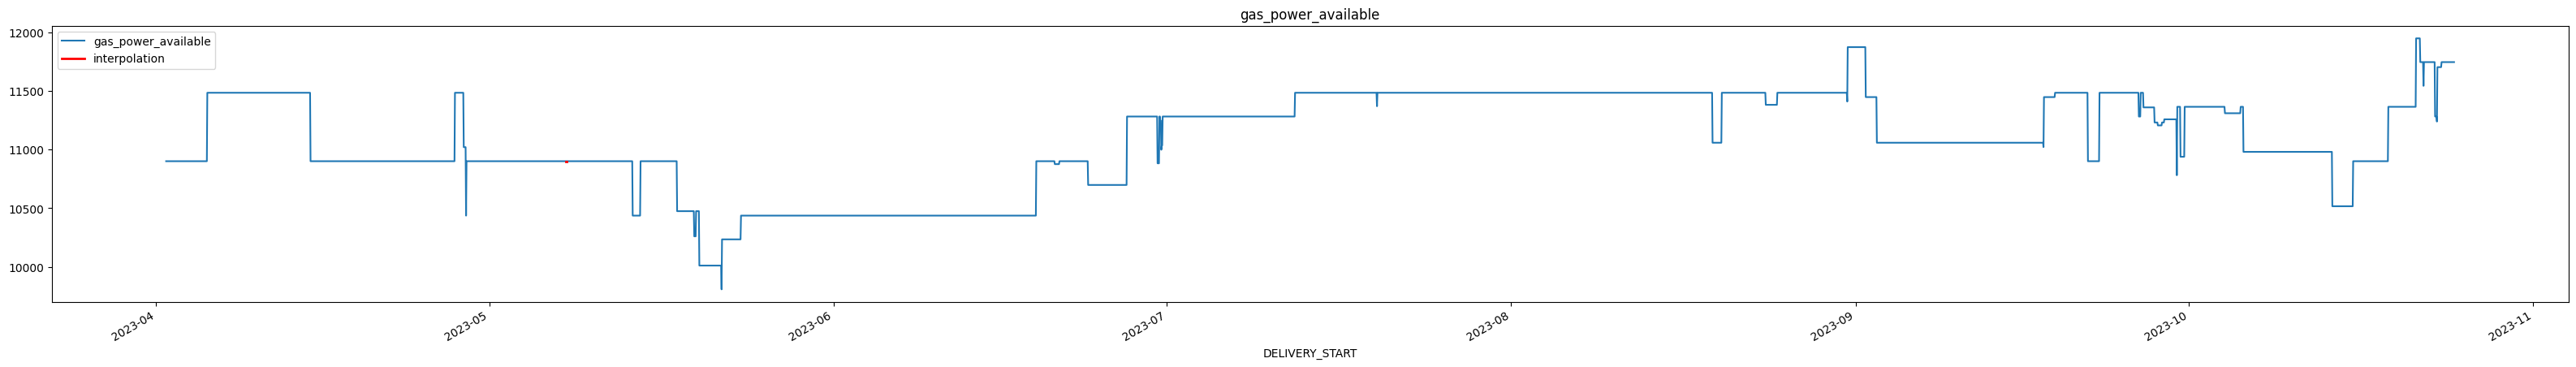

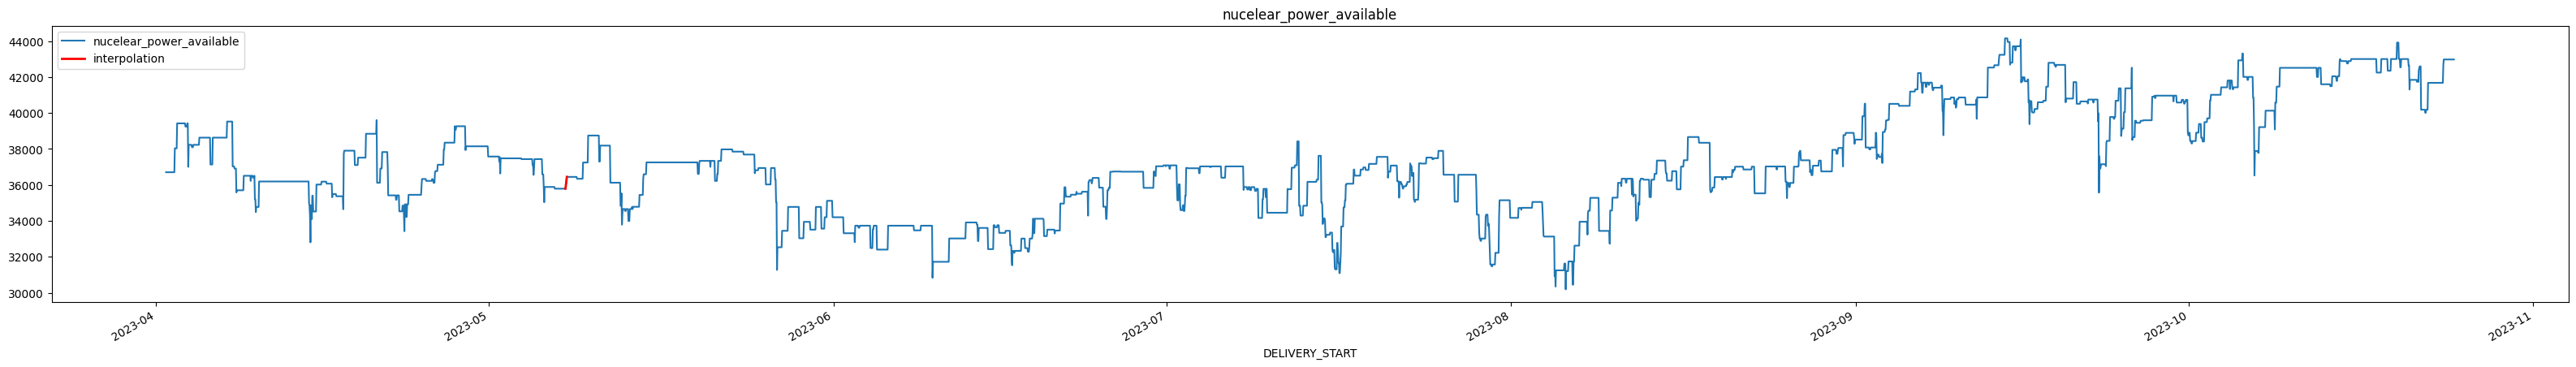

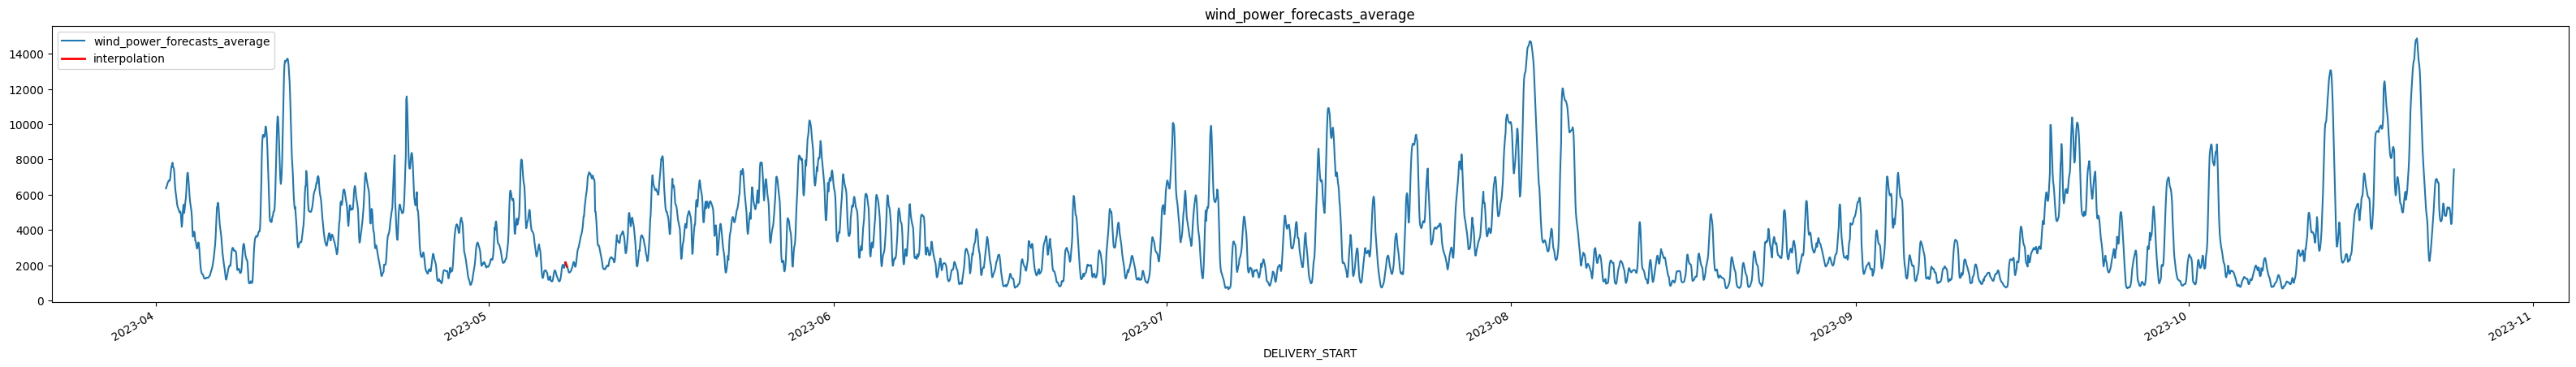

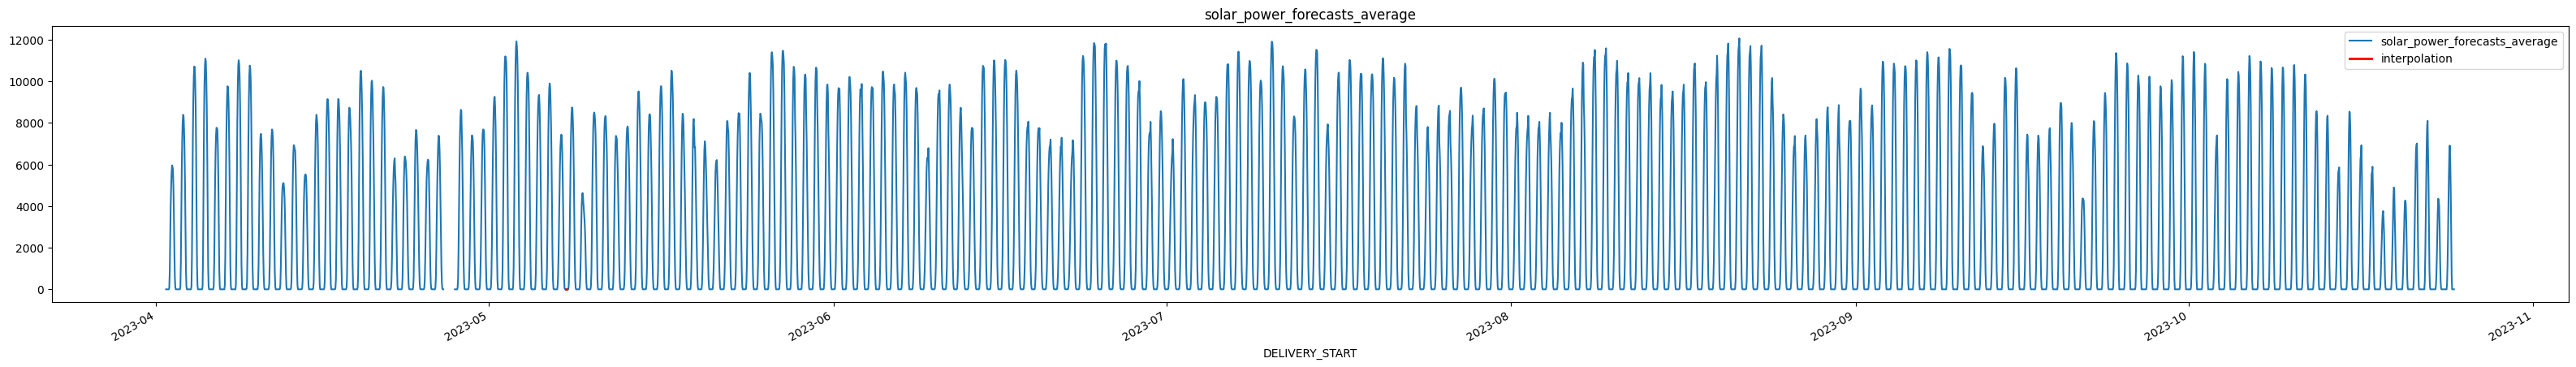

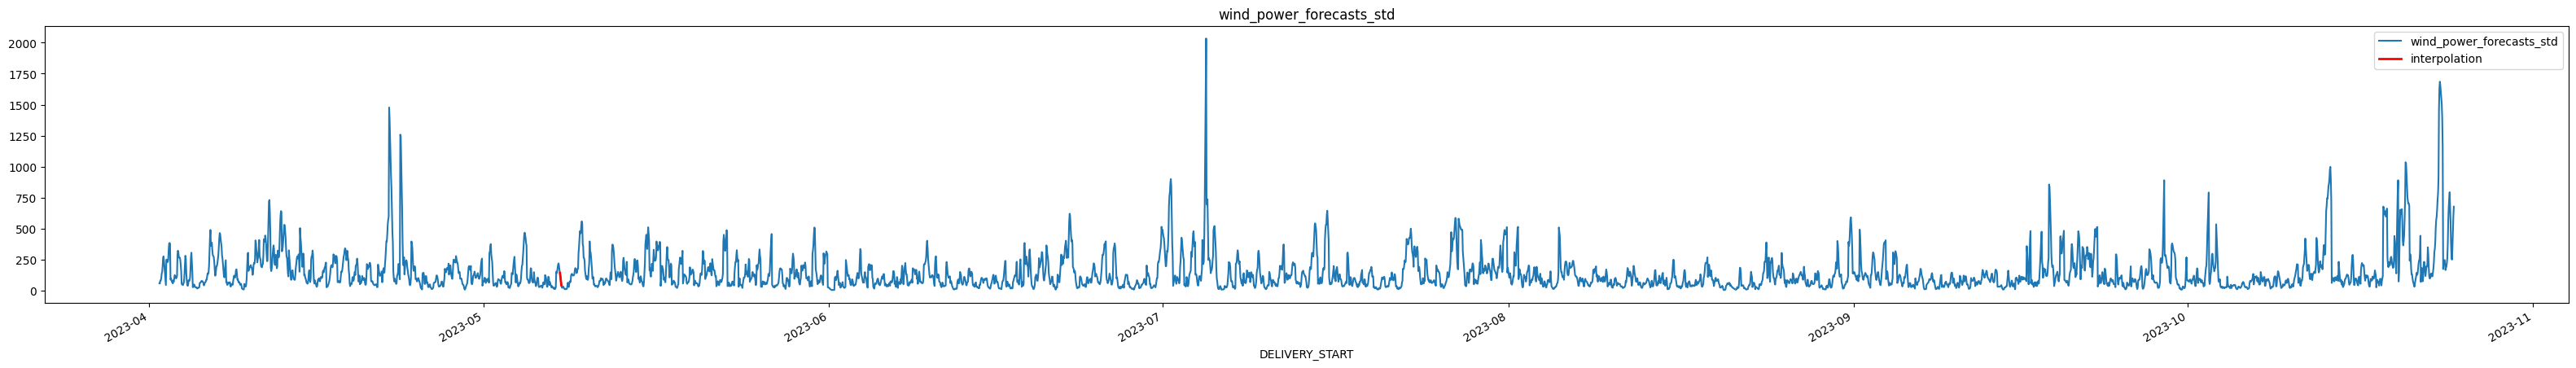

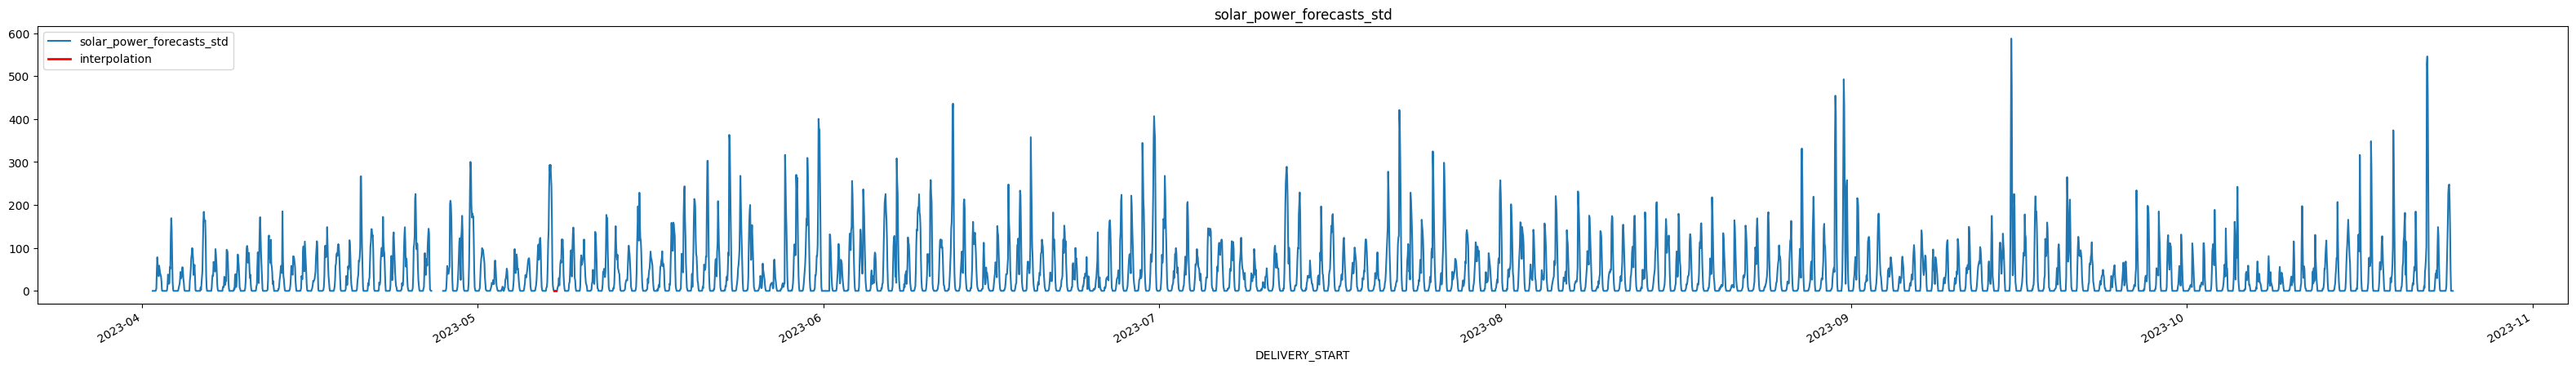

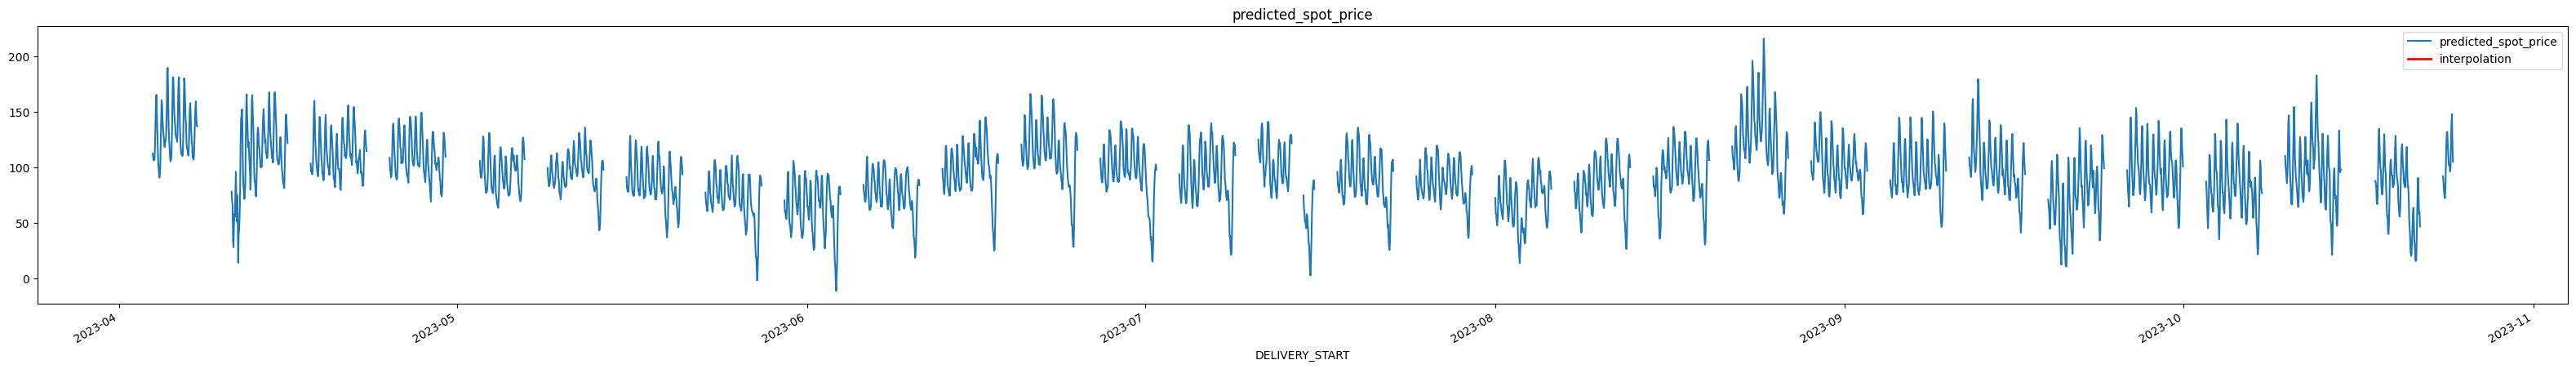

In [21]:
for col in x_test.columns:
    plt.figure(figsize=(40,5))
    x_test[col].plot()
    for _,line in diff_spacings_test.iterrows():
        x_test[col][line['n-1']:line['n']].plot(color='red',linewidth='2', label = 'interpolation')
    plt.legend()
    plt.title(col)
    plt.show()

## 6. Imputing missing values

### STL

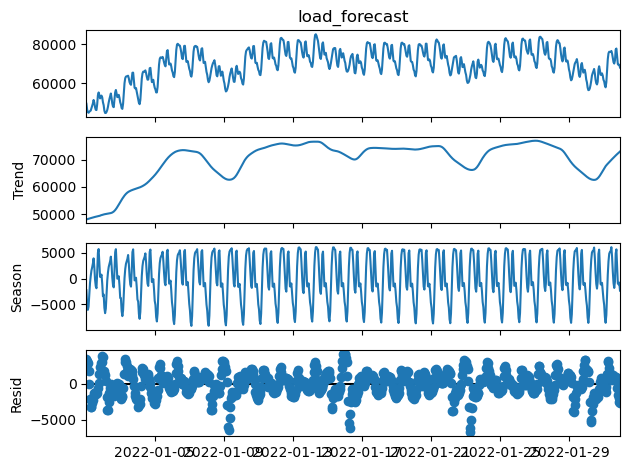

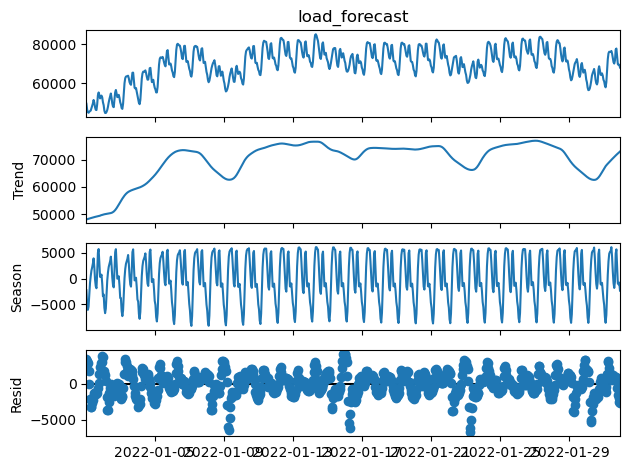

In [21]:
from statsmodels.tsa.seasonal import STL
signal = x_train['load_forecast']['2022-01']
res = STL(signal,seasonal=13).fit()
res.plot()

In [22]:
signal.index.freq

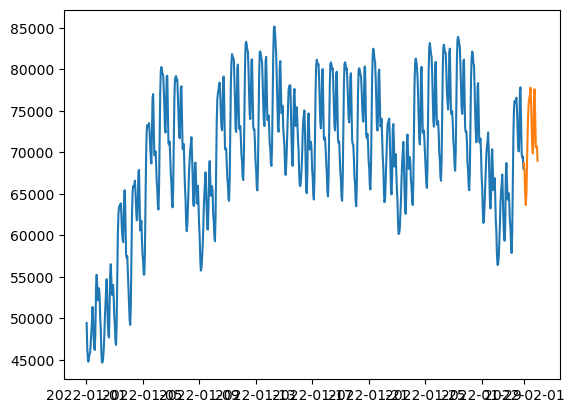

In [23]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.forecasting.stl import STLForecast

signal.index.freq = signal.index.inferred_freq
stlf = STLForecast(signal, ARIMA, model_kwargs=dict(order=(1, 1, 0), trend="t"))
stlf_res = stlf.fit()

forecast = stlf_res.forecast(24)
plt.plot(signal)
plt.plot(forecast)
plt.show()

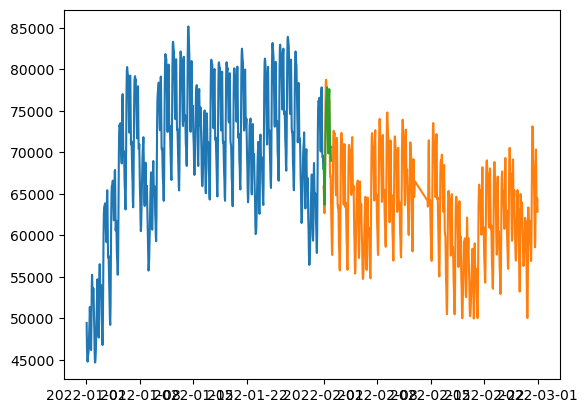

In [24]:
plt.plot(signal)
plt.plot(x_train['load_forecast']['2022-02'])
plt.plot(forecast)

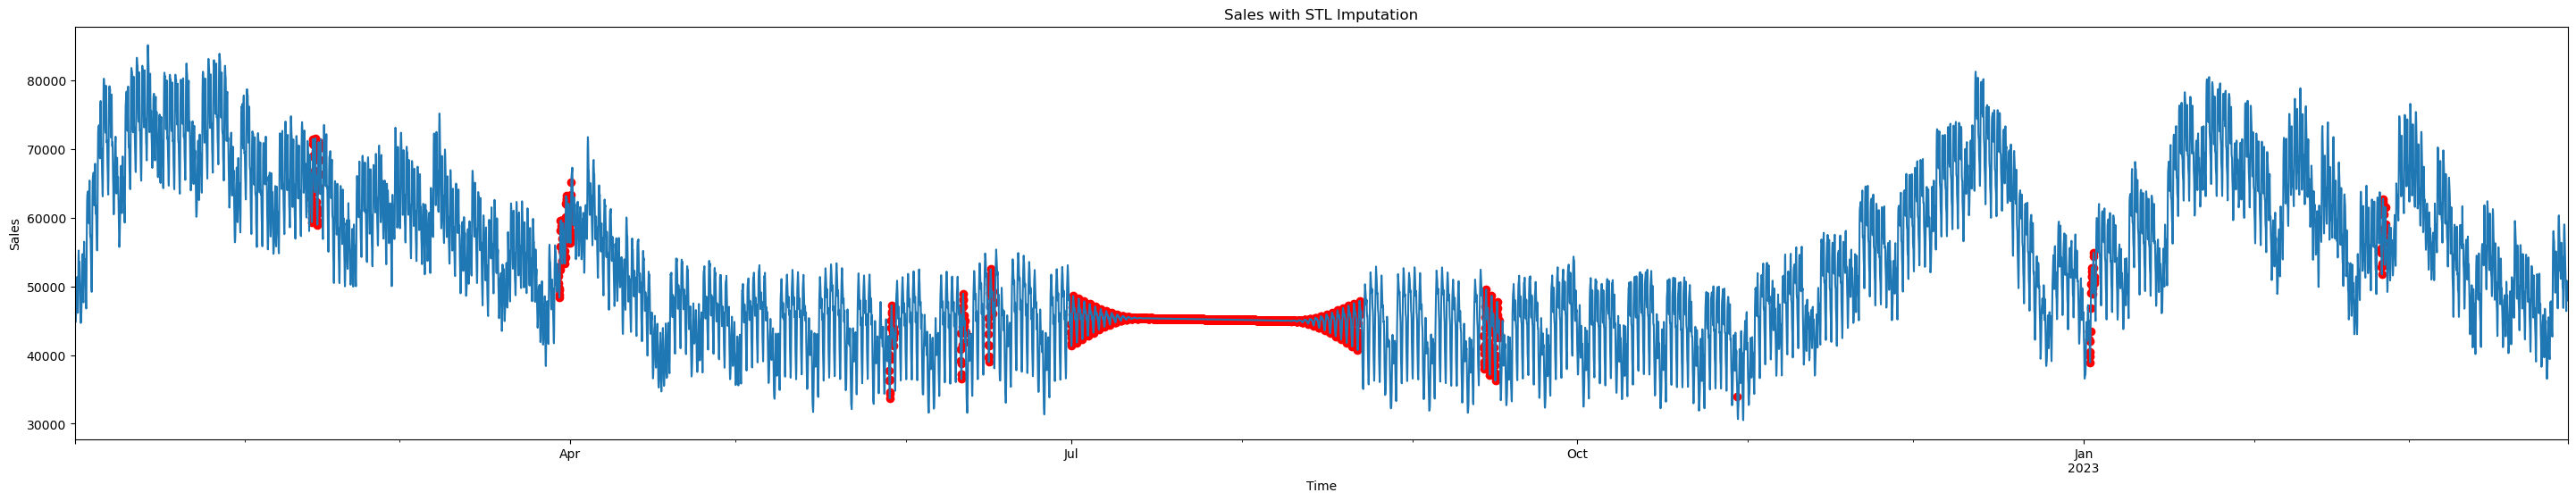

<Axes: xlabel='DELIVERY_START'>

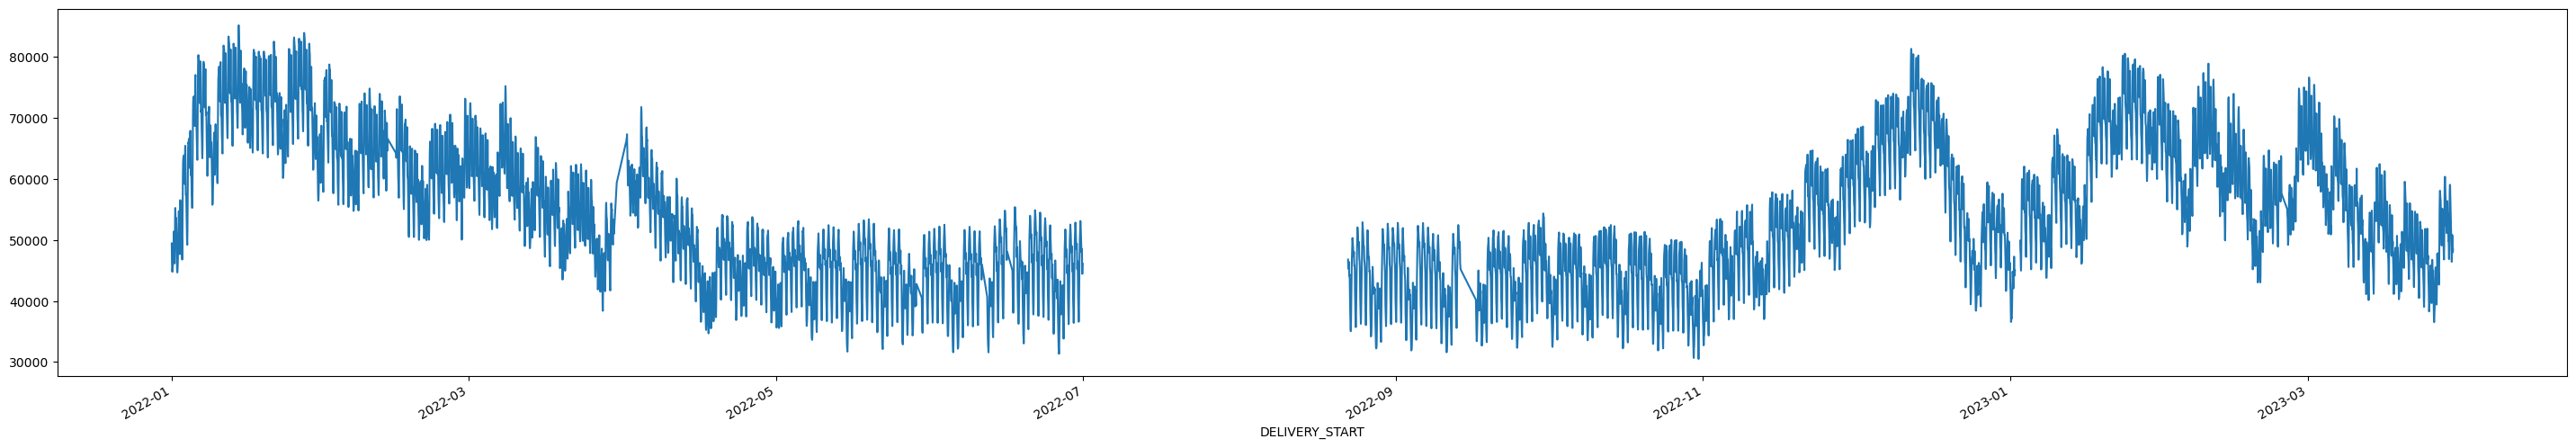

In [25]:
# Make a copy of the original dataframe
x_train_copy = x_train.copy()

x_train_copy = x_train_copy.resample('1h').mean()

# Fill missing values in the time series
imputed_indices = x_train_copy[x_train_copy['load_forecast'].isnull()].index
# Apply STL decompostion
stl = STL(x_train_copy['load_forecast'].interpolate(), seasonal=31)
res = stl.fit()

# Extract the seasonal and trend components
seasonal_component = res.seasonal

# Create the deseasonalised series
x_train_deseasonalised = x_train_copy['load_forecast'] - seasonal_component

# Interpolate missing values in the deseasonalised series
x_train_deseasonalised_imputed = x_train_deseasonalised.interpolate(method="linear")

# Add the seasonal component back to create the final imputed series
x_train_imputed = x_train_deseasonalised_imputed + seasonal_component

# Update the original dataframe with the imputed values
x_train_copy.loc[imputed_indices, 'load_forecast'] = x_train_imputed[imputed_indices]

# Plot the series using pandas
plt.figure(figsize=[36, 6])
x_train_copy['load_forecast'].plot(label='load_forecast')
plt.scatter(imputed_indices, x_train_copy.loc[imputed_indices, 'load_forecast'], color='red')

plt.title("Sales with STL Imputation")
plt.ylabel("Sales")
plt.xlabel("Time")
plt.show()
plt.figure(figsize=[36, 6])
x_train['load_forecast'].plot()


### Trend-seasonality-noise decomposition and interpolation

<Axes: ylabel='DELIVERY_START'>

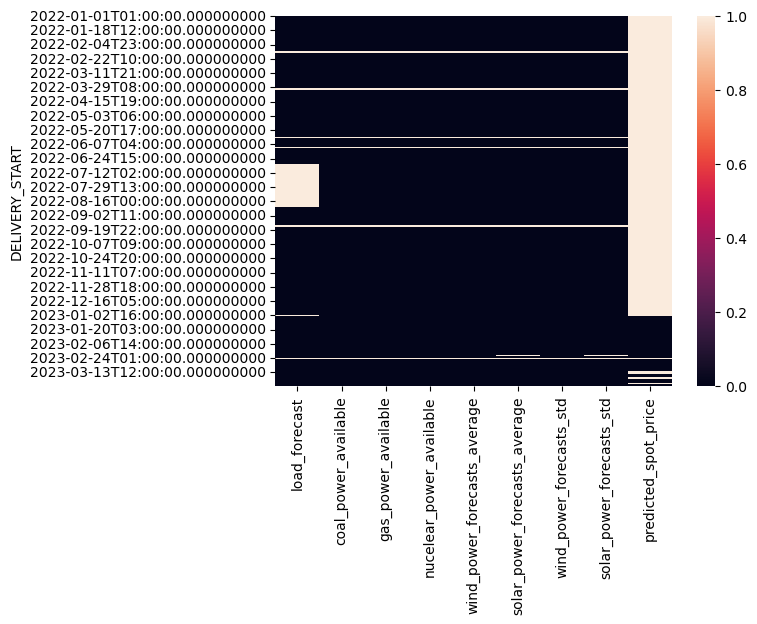

In [39]:
x_train_copy = x_train.copy()
x_train_copy = x_train_copy.resample('1h').mean()
sns.heatmap(x_train_copy.isna())

In [40]:
null_indices = x_train_copy[x_train_copy['load_forecast'].isnull()].index
null_indices

DatetimeIndex(['2022-02-12 23:00:00+00:00', '2022-02-13 00:00:00+00:00',
               '2022-02-13 01:00:00+00:00', '2022-02-13 02:00:00+00:00',
               '2022-02-13 03:00:00+00:00', '2022-02-13 04:00:00+00:00',
               '2022-02-13 05:00:00+00:00', '2022-02-13 06:00:00+00:00',
               '2022-02-13 07:00:00+00:00', '2022-02-13 08:00:00+00:00',
               ...
               '2023-02-24 13:00:00+00:00', '2023-02-24 14:00:00+00:00',
               '2023-02-24 15:00:00+00:00', '2023-02-24 16:00:00+00:00',
               '2023-02-24 17:00:00+00:00', '2023-02-24 18:00:00+00:00',
               '2023-02-24 19:00:00+00:00', '2023-02-24 20:00:00+00:00',
               '2023-02-24 21:00:00+00:00', '2023-02-24 22:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='DELIVERY_START', length=1551, freq=None)

In [41]:
null_patches = []
patch = []
for i in range(len(null_indices)-1):
    patch.append(null_indices[i])
    if null_indices[i+1] != null_indices[i]+pd.Timedelta('1h'):
        null_patches.append(patch)
        patch = []
len(null_patches)

10

In [42]:
patches_len = list(map(lambda p : len(p), null_patches))
longest_patch_ind = np.argmax(patches_len)

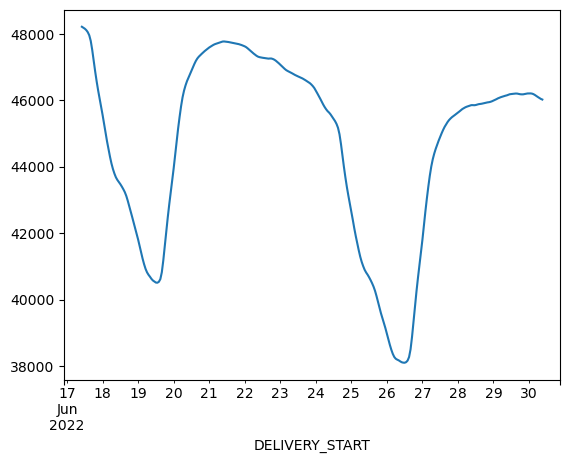

<Axes: xlabel='DELIVERY_START'>

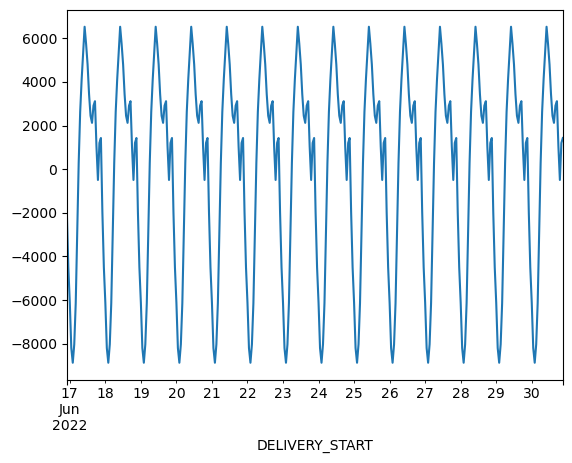

In [43]:
from statsmodels.tsa.seasonal import seasonal_decompose

l1 = null_patches[longest_patch_ind-1][-1] + pd.Timedelta('1h')
l2 = null_patches[longest_patch_ind][0] - pd.Timedelta('1h')
left = x_train_copy['load_forecast'][l1:l2]

decomposition_left = seasonal_decompose(left, model='additive')
decomposition_left.trend.plot()
plt.show()
decomposition_left.seasonal.plot()

In [44]:
#UTILITY FUNCTION
from scipy.signal import argrelmax, periodogram

def get_largest_local_max(
    signal1D: np.ndarray, n_largest: int = 3, order: int = 1) -> [np.ndarray, np.ndarray]:
    """Return the largest local max and the associated index in a tuple.

    This function uses `order` points on each side to use for the comparison.
    """
    all_local_max_indexes = argrelmax(signal1D, order=order)[0]
    all_local_max = np.take(signal1D, all_local_max_indexes)
    largest_local_max_indexes = all_local_max_indexes[all_local_max.argsort()[::-1]][
        :n_largest
    ]

    return (
        np.take(signal1D, largest_local_max_indexes),
        largest_local_max_indexes,
    )

<Axes: xlabel='DELIVERY_START'>

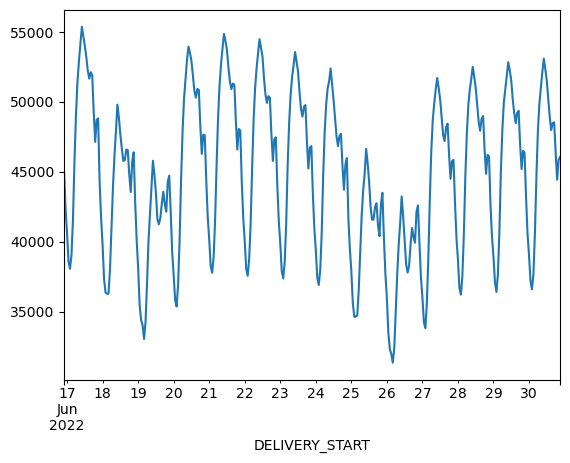

In [45]:
signal = left
time_array = np.arange(signal.size)
signal.plot()

array([0.00666667, 0.04666667, 0.00333333])

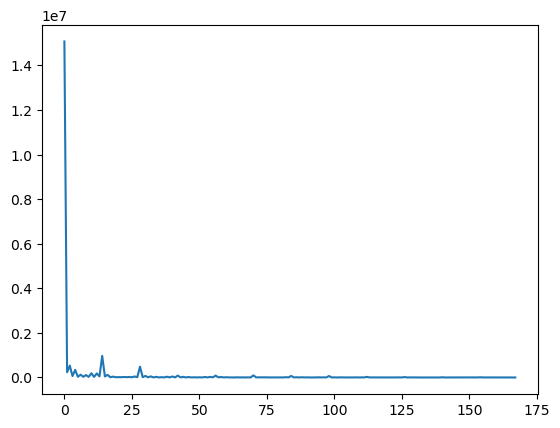

In [46]:
fft_values = np.fft.fft(signal)
frequencies = np.fft.fftfreq(len(signal), 3600)
positive_freqs = frequencies[:len(frequencies)//2]
magnitude_spectrum = np.abs(fft_values[:len(fft_values)//2])
plt.plot(magnitude_spectrum)
max_freq, max_freq_idx =get_largest_local_max(magnitude_spectrum)
freqs = frequencies[max_freq_idx]*3600
(1/freqs)/3600

In [47]:
A_matrix = np.array([(np.cos(2 * np.pi * fi * time_array),np.sin(2 * np.pi * fi * time_array)) for fi in freqs])
A_matrix = A_matrix.reshape(len(freqs)*2,-1)
A_matrix = np.vstack((A_matrix, np.array([np.ones(time_array.size)])))
A_matrix = A_matrix.T

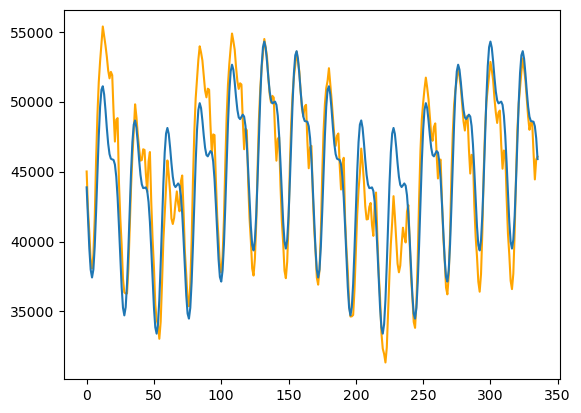

In [48]:
coefs = np.linalg.lstsq(A_matrix, signal, rcond=None)[0]
plt.plot(time_array, signal, label="Original", color='orange')
plt.plot(time_array, A_matrix @ coefs, label="Model")

In [49]:
target_time_array = x_train_copy['load_forecast']
target_time_array_ind = np.arange(len(target_time_array))

In [50]:
A_matrix = np.array([(np.cos(2 * np.pi * fi * target_time_array_ind),np.sin(2 * np.pi * fi * target_time_array_ind)) for fi in freqs])
A_matrix = A_matrix.reshape(len(freqs)*2,-1)
A_matrix = np.vstack((A_matrix, np.array([np.ones(target_time_array_ind.size)])))
A_matrix = A_matrix.T
pred = A_matrix @ coefs

<Axes: xlabel='DELIVERY_START'>

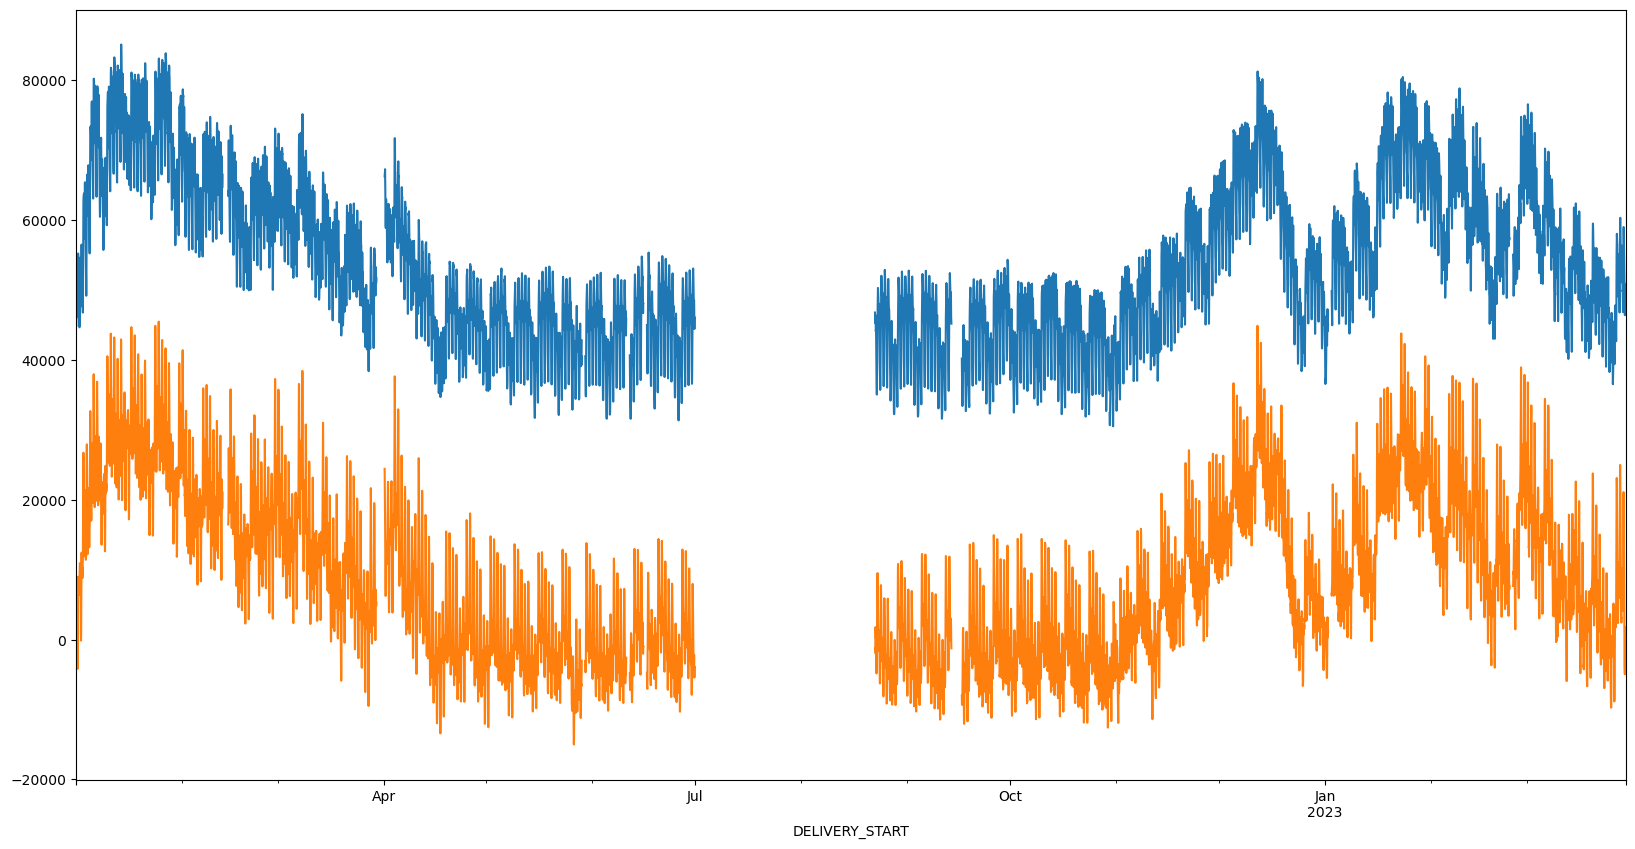

In [55]:
plt.figure(figsize=(20,10))
x_train_copy['load_forecast'].plot()
x_train_copy['new_col'] = x_train_copy['load_forecast'] - pred
x_train_copy['new_col'].plot()

<Axes: xlabel='DELIVERY_START'>

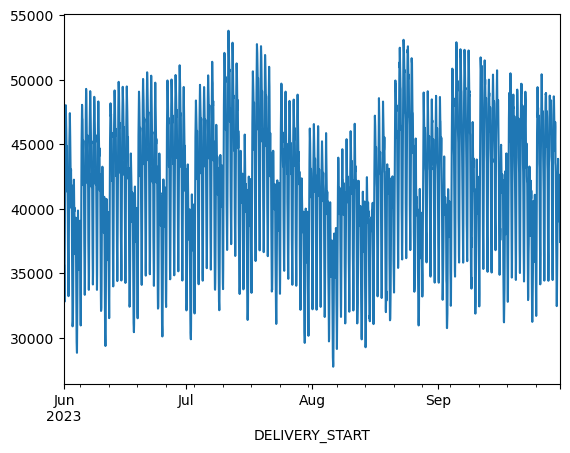

In [21]:
x_test['load_forecast']['06-2023':'09-2023'].plot()

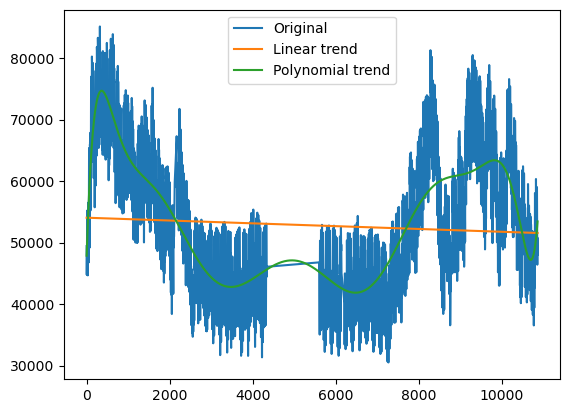

In [58]:
signal_train = x_train_copy['load_forecast'].interpolate()
time_array_train = np.arange(len(signal_train.index))
coeffs = np.polyfit(time_array_train, signal_train, 1)
approx_linear_trend = np.polyval(coeffs, time_array_train)

coeffs = np.polyfit(time_array_train, signal_train, 13)
approx_poly_trend = np.polyval(coeffs, time_array_train)


plt.plot(time_array_train,signal_train, label="Original")

plt.plot(approx_linear_trend, label="Linear trend")
plt.plot(approx_poly_trend, label="Polynomial trend")
plt.legend()

In [ ]:
x_train_copy['seasonal'] = pred
x_train_copy['trend'] = approx_poly_trend
